In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2 as cv

In [3]:
from data_quality_stats import missing_data, unique_values, most_frequent_values
from plot_style_utils import set_color_map, plot_count
from video_utils import display_image_from_video, display_images_from_video_list, play_video
from face_object_detection import CascadeObjectDetector, FaceObjectDetector
from face_detection_mtcnn import MTCNNFaceDetector

In [4]:
import os
import random
import shutil

DATA_FOLDER = 'Datasets/CELEBA'
ALL_IMAGES_FOLDER = 'CELEBA/'
TRAIN_FOLDER = 'train_img'
TEST_FOLDER = 'test_img'
VALID_FOLDER = 'validate_img'

os.makedirs(os.path.join(DATA_FOLDER, TRAIN_FOLDER), exist_ok=True)
os.makedirs(os.path.join(DATA_FOLDER, TEST_FOLDER), exist_ok=True)
os.makedirs(os.path.join(DATA_FOLDER, VALID_FOLDER), exist_ok=True)

# Get all image files
all_images = os.listdir(os.path.join(DATA_FOLDER, ALL_IMAGES_FOLDER))
print(f"Total images: {len(all_images)}")

# Set the ratio for train-test-validation split (e.g., 70% for training, 20% for testing, 10% for validation)
train_ratio = 0.7
test_ratio = 0.2

# Calculate the number of images for each split
num_train_img = int(len(all_images) * train_ratio)
num_test_img = int(len(all_images) * test_ratio)
num_valid_img = len(all_images) - num_train_img - num_test_img
print(f"Number of images for training: {num_train_img}")
print(f"Number of images for testing: {num_test_img}")
print(f"Number of images for validation: {num_valid_img}")

# Randomly select images for training
train_img = random.sample(all_images, num_train_img)
print(f"Selected {len(train_img)} images for training")

# Select the rest of the images for testing and validation
remaining_images = [img for img in all_images if img not in train_img]
test_img = random.sample(remaining_images, num_test_img)
print(f"Selected {len(test_img)} images for testing")

valid_img = [img for img in remaining_images if img not in test_img]
print(f"Selected {len(valid_img)} images for validation")

# Move the images to respective folders
for img in train_img:
    shutil.move(os.path.join(DATA_FOLDER, ALL_IMAGES_FOLDER, img),
                os.path.join(DATA_FOLDER, TRAIN_FOLDER, img))

for img in test_img:
    shutil.move(os.path.join(DATA_FOLDER, ALL_IMAGES_FOLDER, img),
                os.path.join(DATA_FOLDER, TEST_FOLDER, img))

for img in valid_img:
    shutil.move(os.path.join(DATA_FOLDER, ALL_IMAGES_FOLDER, img),
                os.path.join(DATA_FOLDER, VALID_FOLDER, img))

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")
print(f"Validation samples: {len(os.listdir(os.path.join(DATA_FOLDER, VALID_FOLDER)))}")


Total images: 0
Number of images for training: 0
Selected 0 images for training
Selected 0 images for testing
Train samples: 28780
Test samples: 7196


In [5]:
train_list = list(os.listdir(os.path.join(DATA_FOLDER, TRAIN_FOLDER)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")


Extensions: ['jpg']


In [5]:
import os
import cv2
import pandas as pd
import numpy as np

def calculate_color_distribution(img):
    # Convert image to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Calculate histogram for each channel
    h_hist = cv2.calcHist([hsv_img], [0], None, [256], [0, 256])
    s_hist = cv2.calcHist([hsv_img], [1], None, [256], [0, 256])
    v_hist = cv2.calcHist([hsv_img], [2], None, [256], [0, 256])
    
    # Normalize histograms
    h_hist /= np.sum(h_hist)
    s_hist /= np.sum(s_hist)
    v_hist /= np.sum(v_hist)
    
    return h_hist, s_hist, v_hist

In [8]:
def img_stat(img_dir):
    # List all files in the directory
    img_files = os.listdir(img_dir)
    
    # List to store image statistics
    data = []
    
    # Iterate through each image file to load and perform additional processing
    for img_file in img_files:
        img_path = os.path.join(img_dir, img_file)
        if os.path.isfile(img_path):
            # Read image
            img = cv2.imread(img_path)
            if img is not None:
                # Get image properties
                height, width, _ = img.shape
                aspect_ratio = width / height
                
                # Calculate color distribution
                h_hist, s_hist, v_hist = calculate_color_distribution(img)
                
                # Append to the list
                data.append({'Image Name': img_file, 'Width': width, 'Height': height, 
                             'Aspect Ratio': aspect_ratio, 
                             'Hue Histogram': h_hist, 'Saturation Histogram': s_hist, 'Value Histogram': v_hist})
    
    # Convert the list to a DataFrame
    df = pd.DataFrame(data)
    
    return df


In [38]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import base64
from io import BytesIO
from skimage.metrics import structural_similarity as ssim
from IPython.display import display, HTML

def plot_similarity_score(image_paths):
    num_images = len(image_paths)
    similarity_scores = np.zeros((num_images, num_images))
    for i, img_path1 in enumerate(image_paths):
        for j, img_path2 in enumerate(image_paths):
            img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
            similarity_scores[i, j] = ssim(img1, img2)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_scores, cmap='viridis')
    plt.colorbar(label='SSIM Score')
    plt.title('Structural Similarity Score')
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.xticks(np.arange(num_images), np.arange(1, num_images + 1))
    plt.yticks(np.arange(num_images), np.arange(1, num_images + 1))
    plt.grid(False)
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    similarity_plot_b64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    return f'<img src="data:image/png;base64,{similarity_plot_b64}" width="600" />'



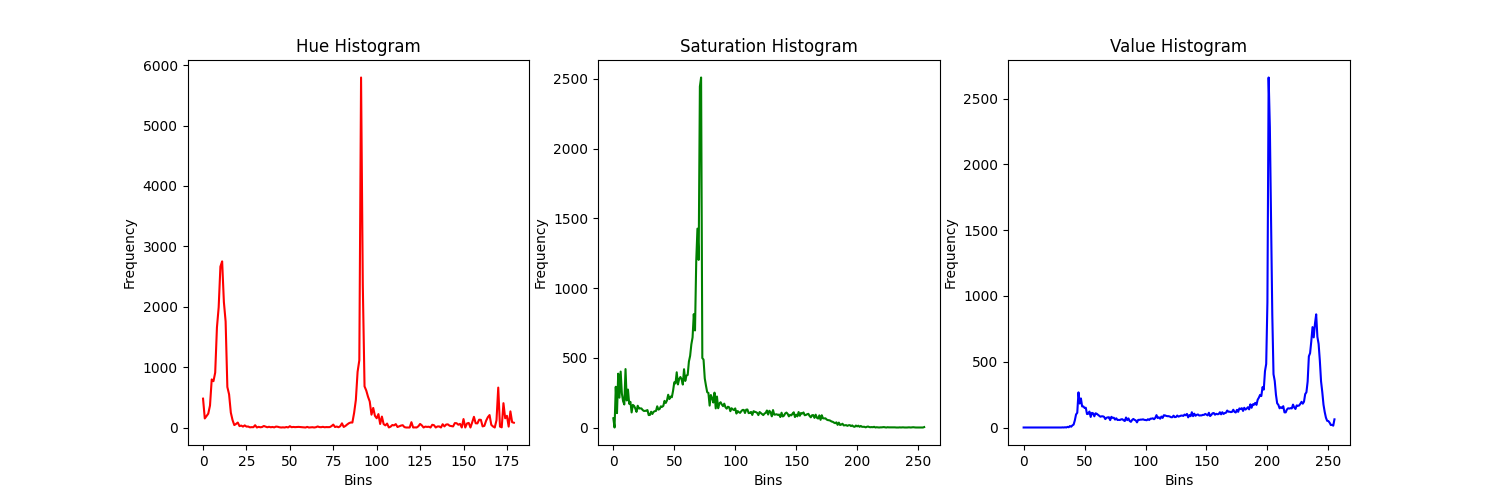
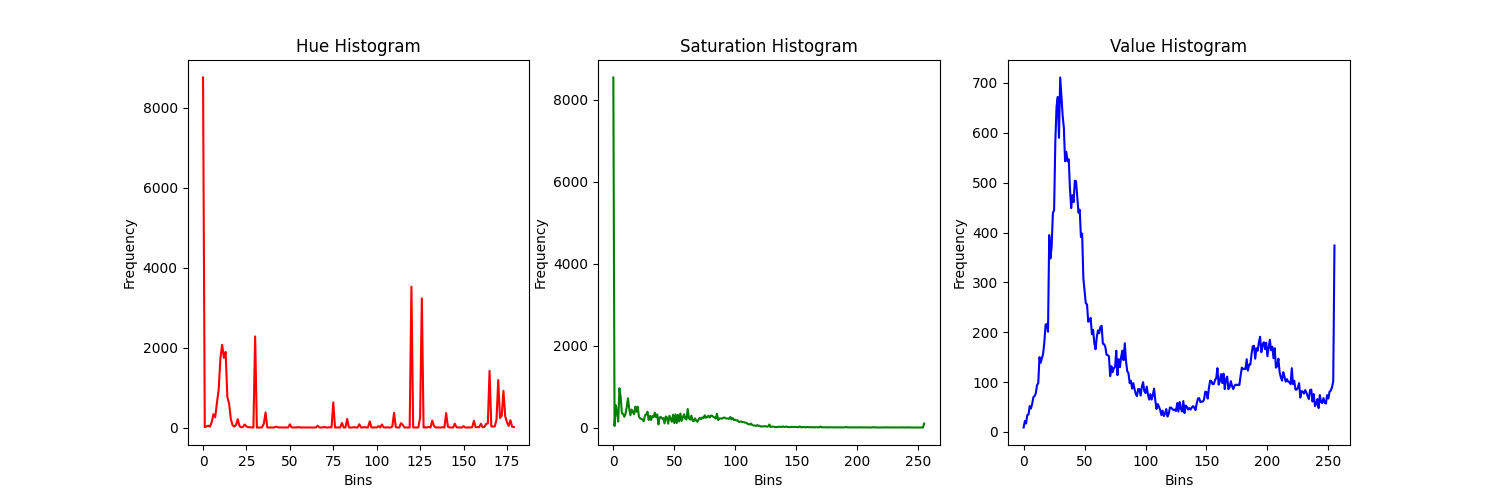
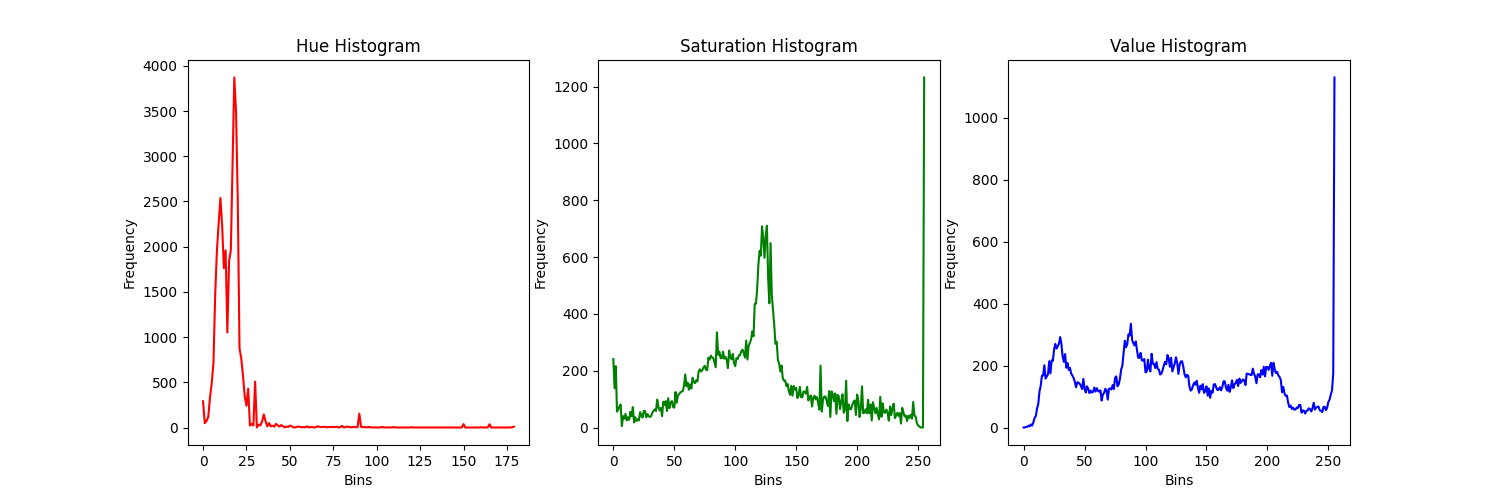
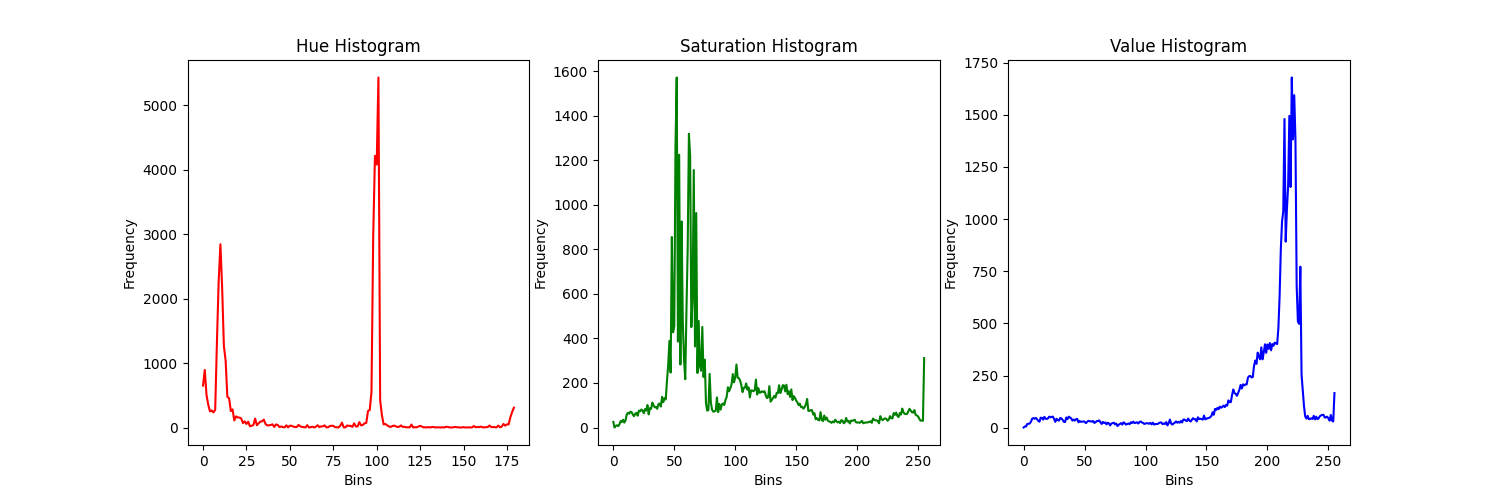
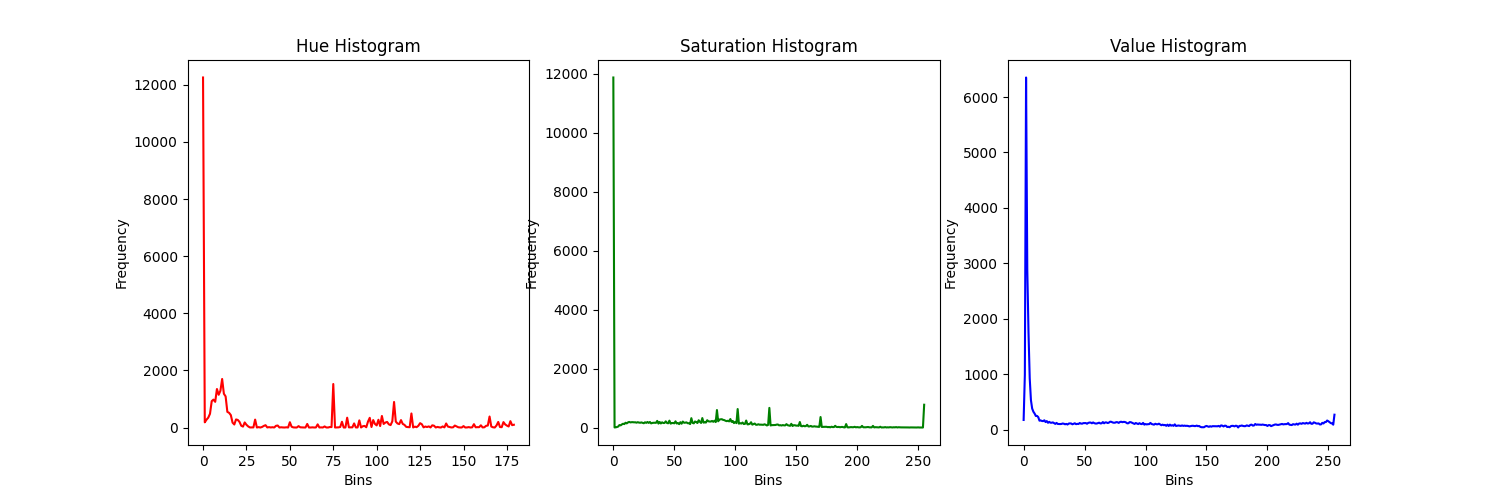
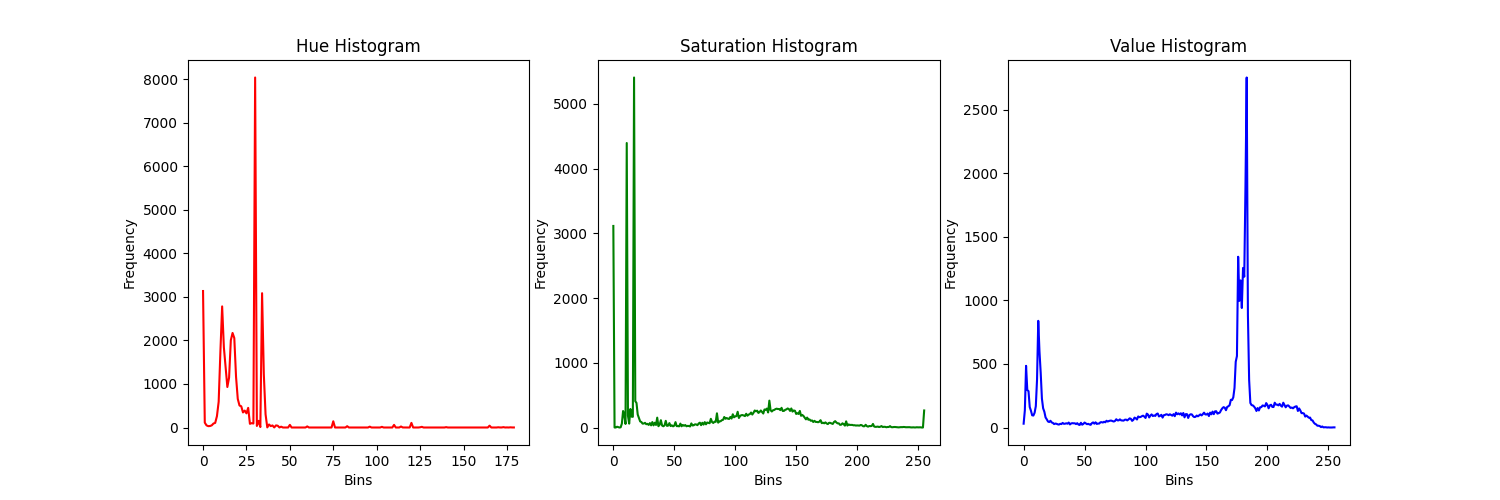
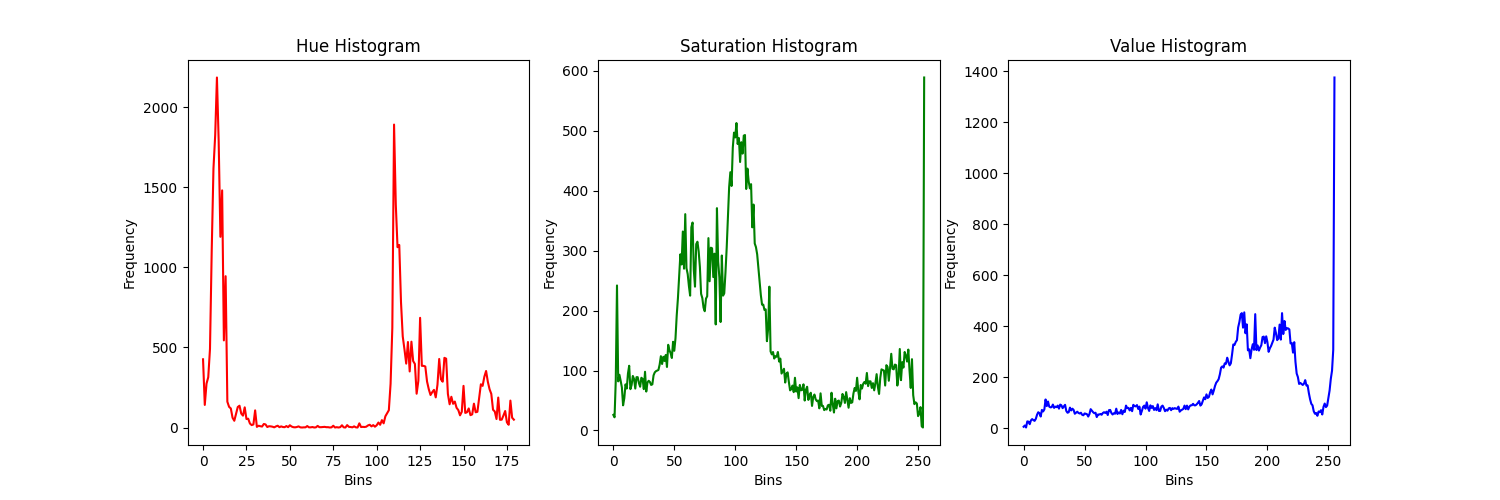
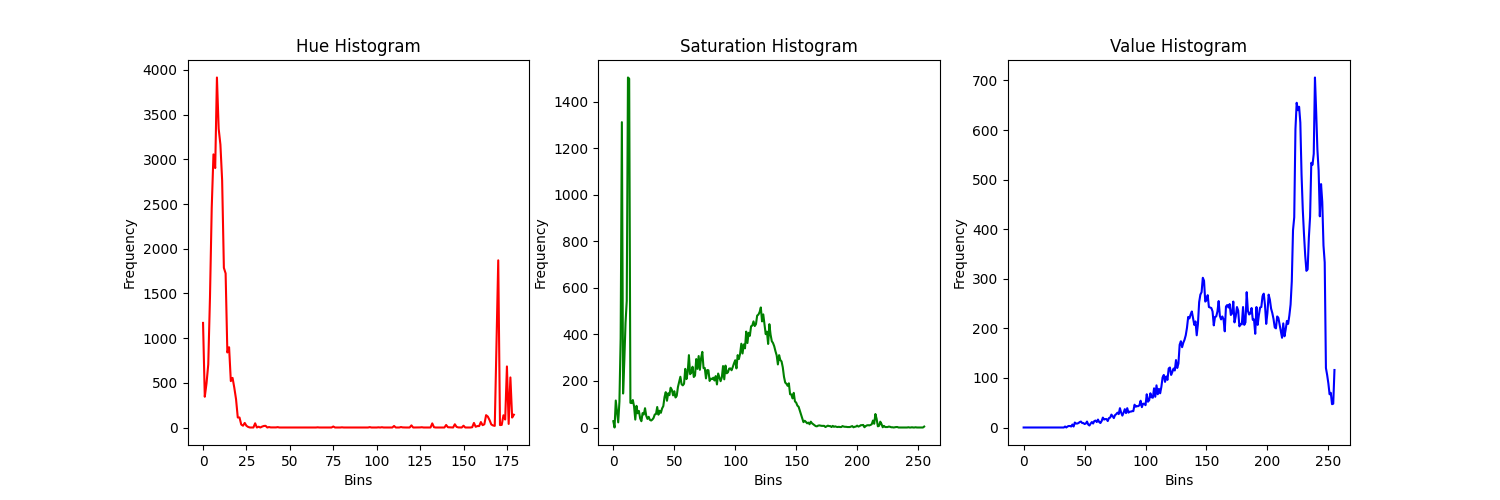
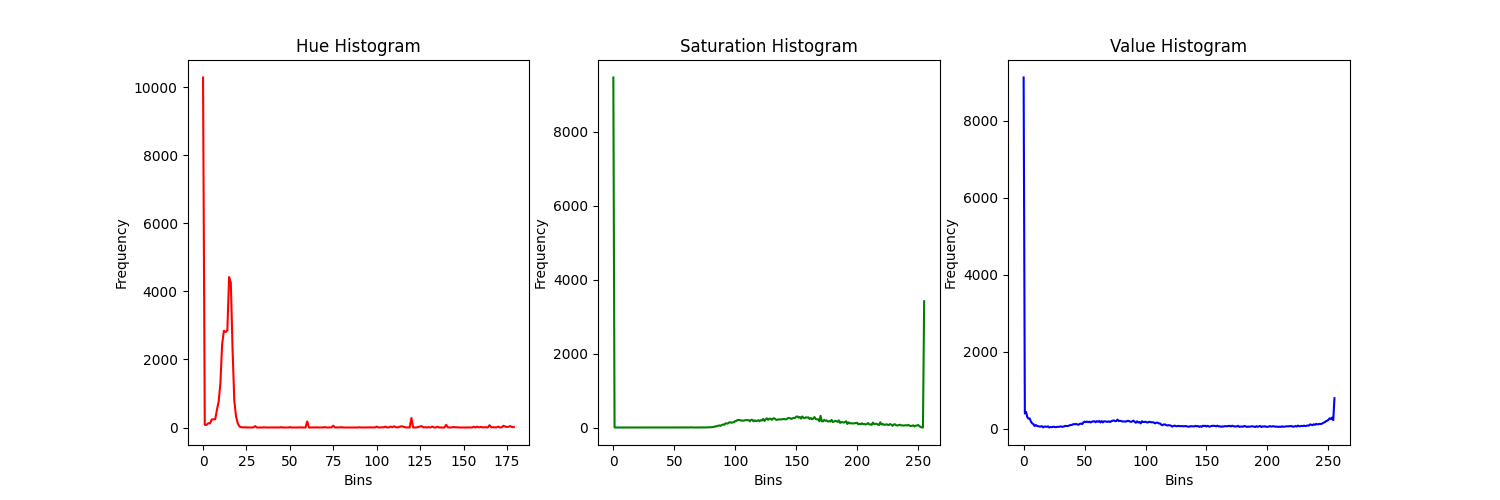
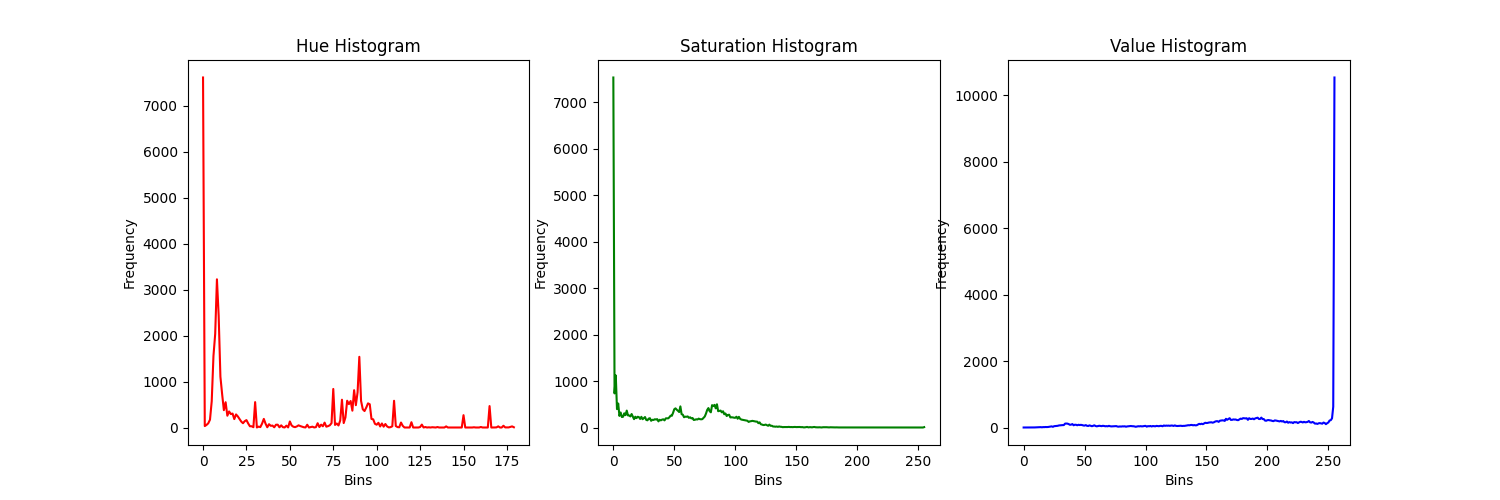
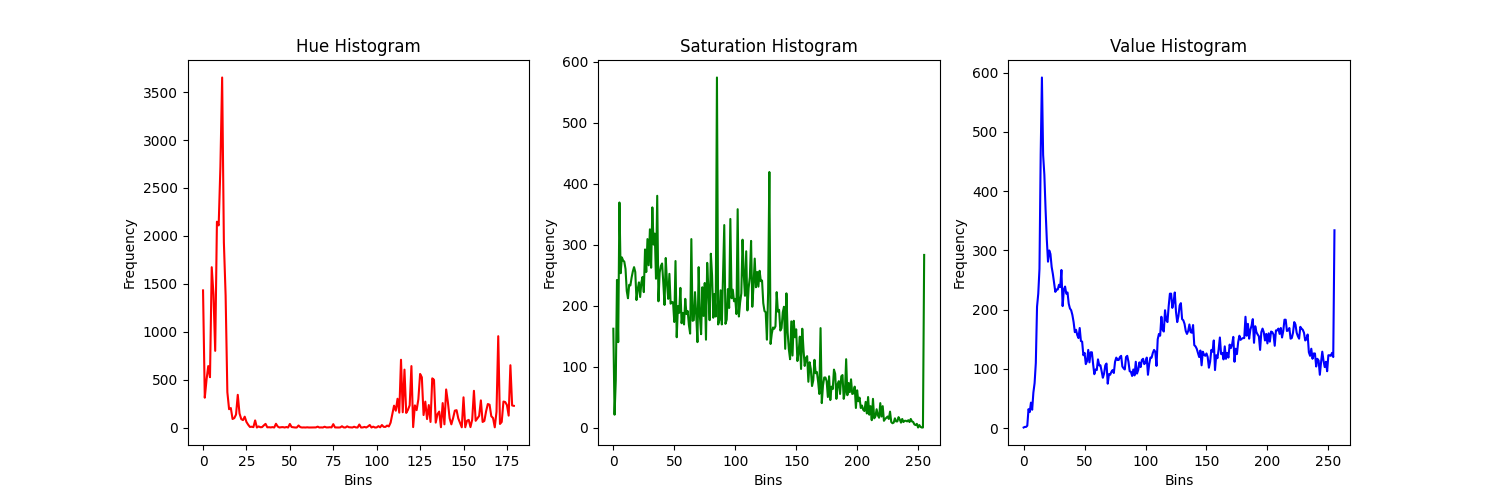
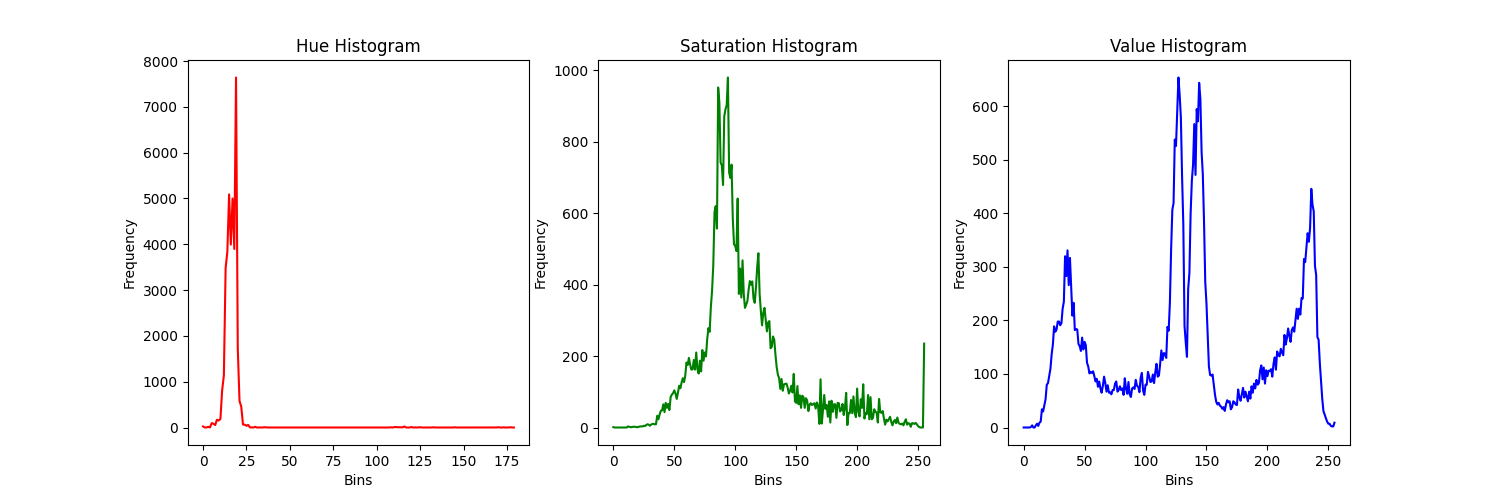
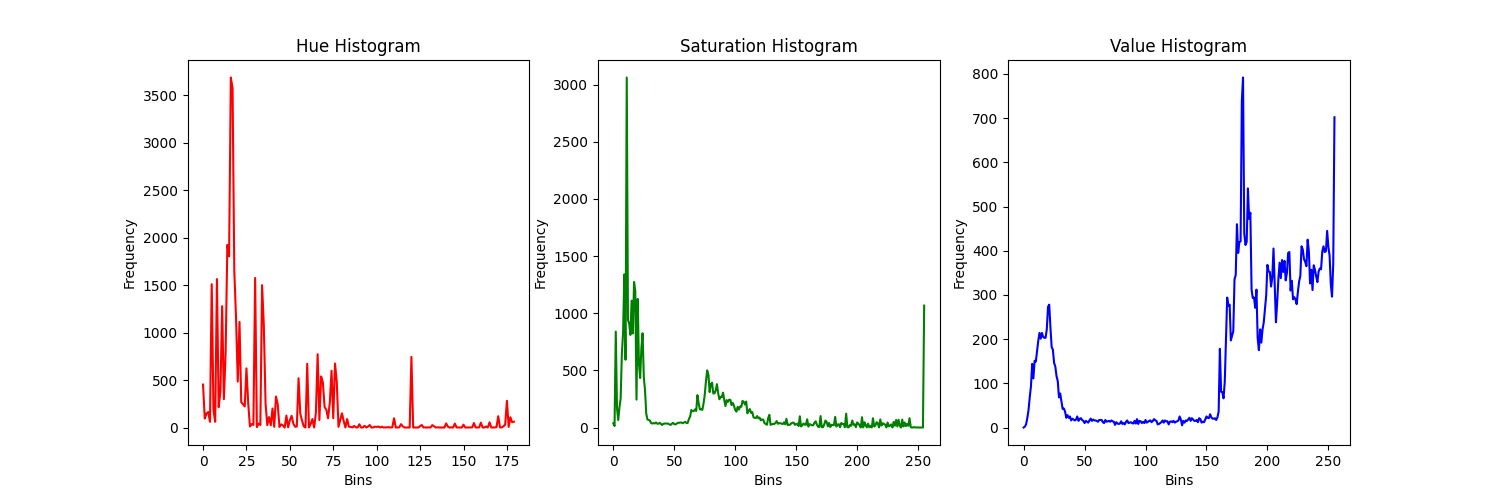
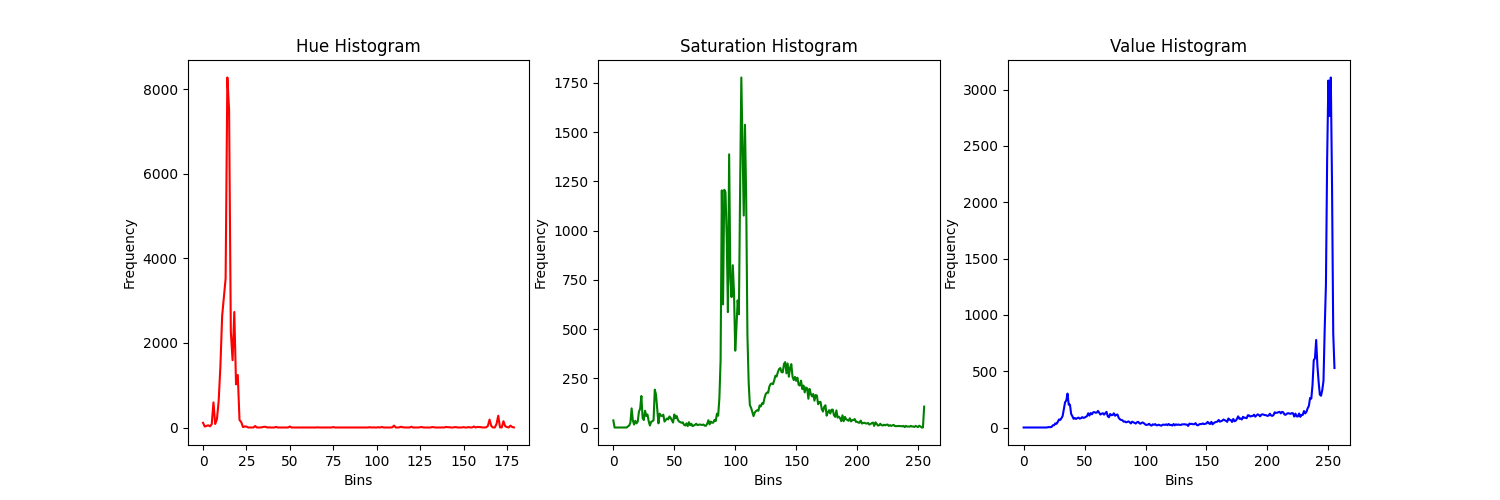
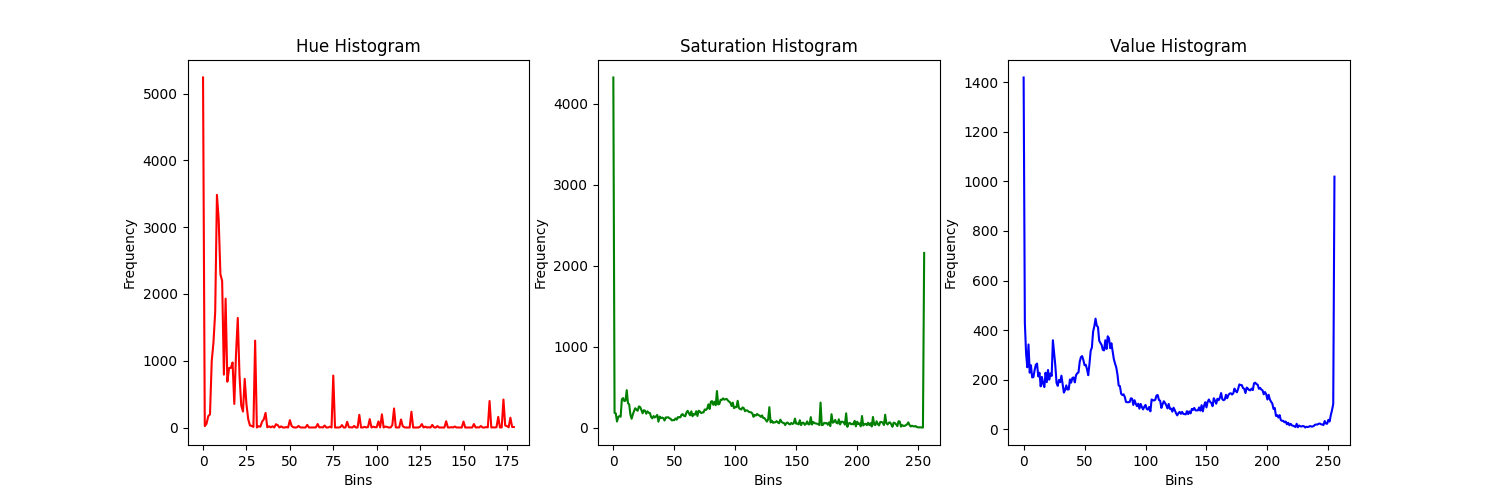
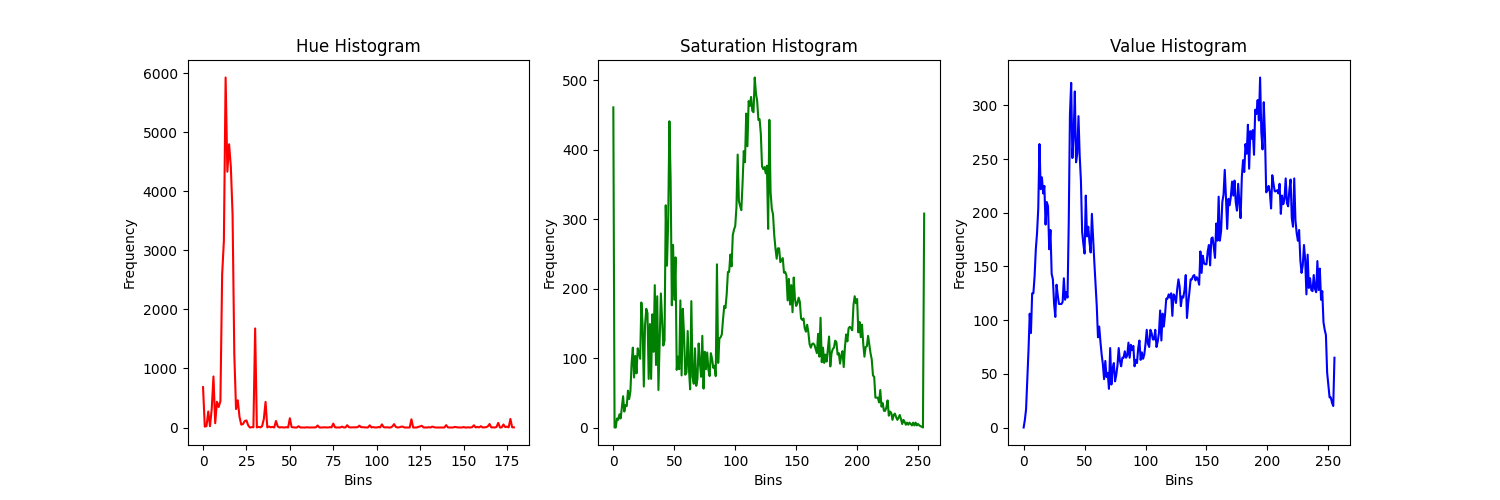
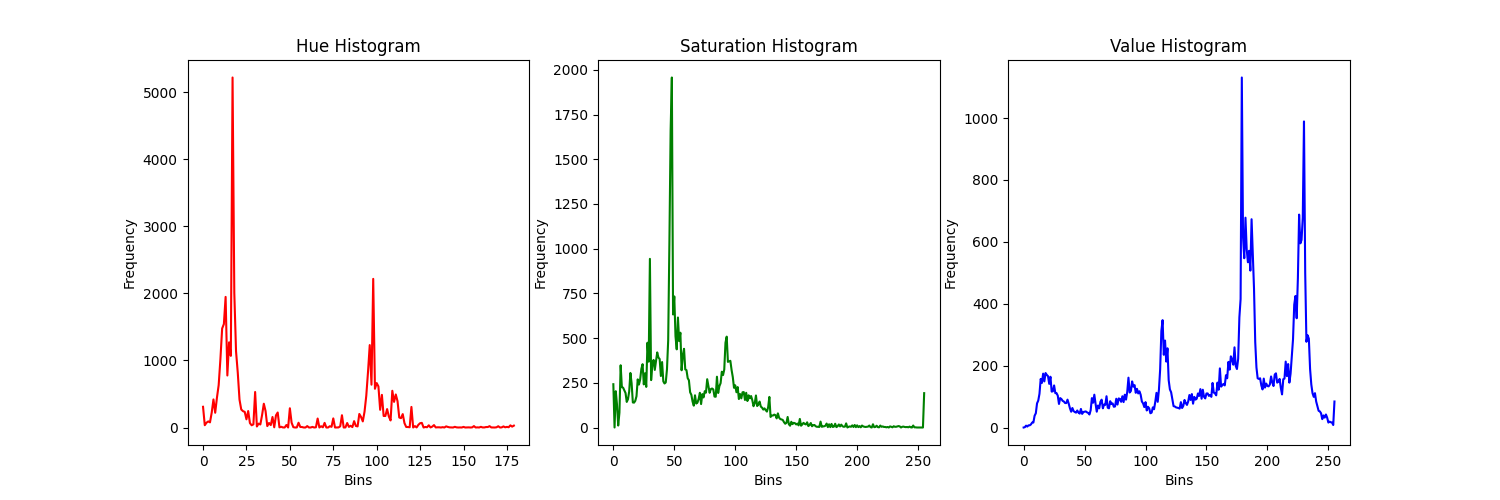
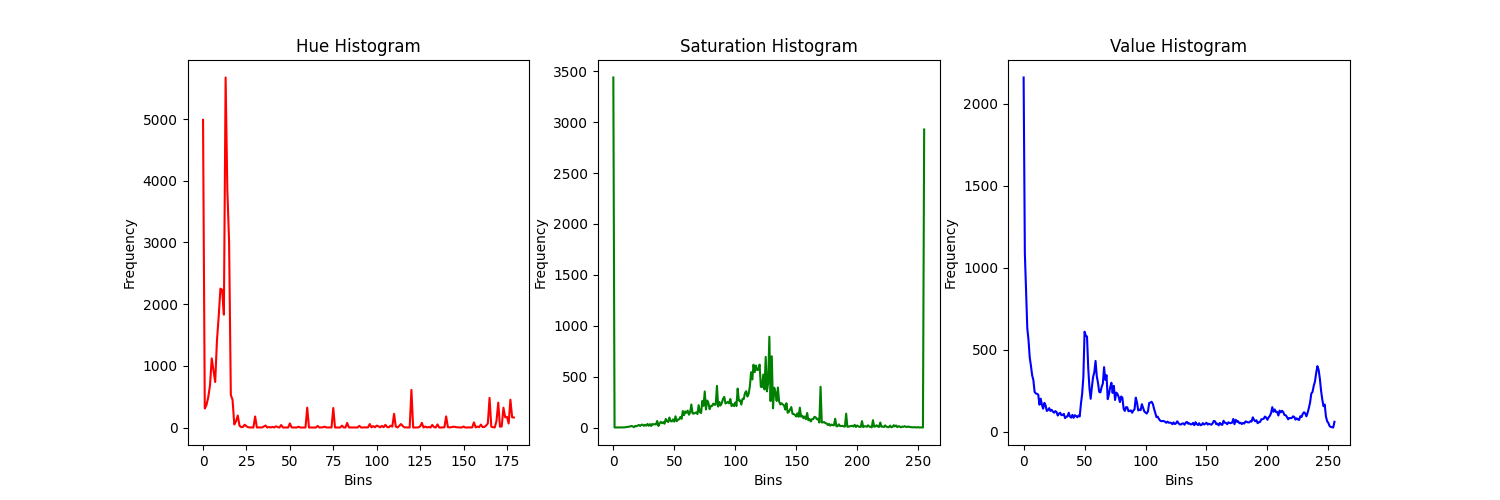
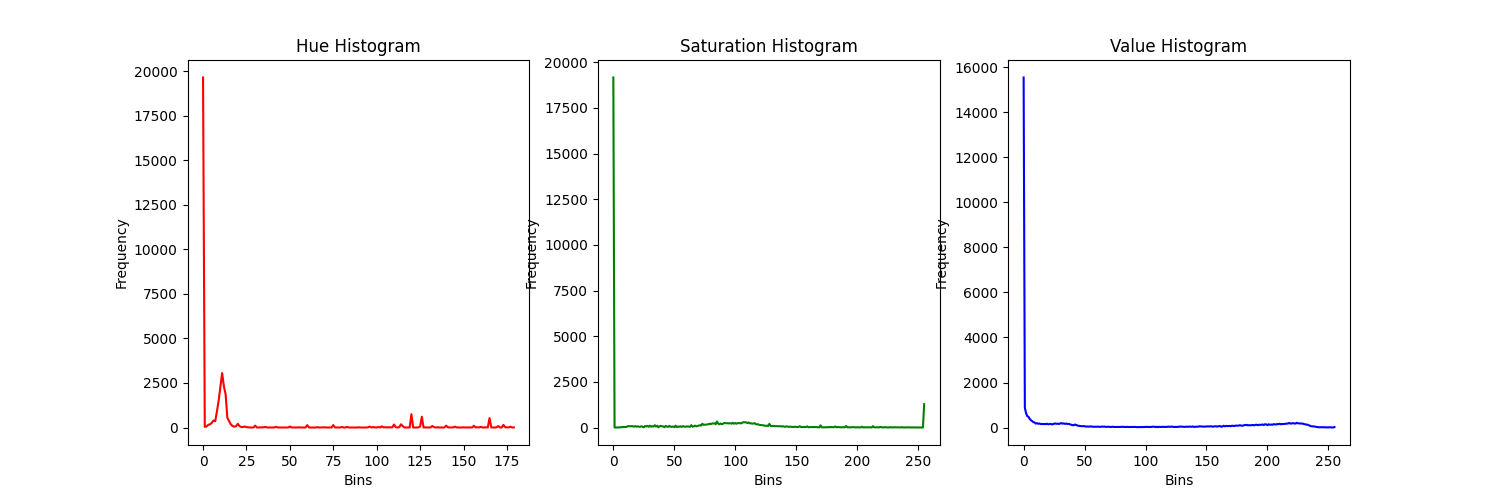
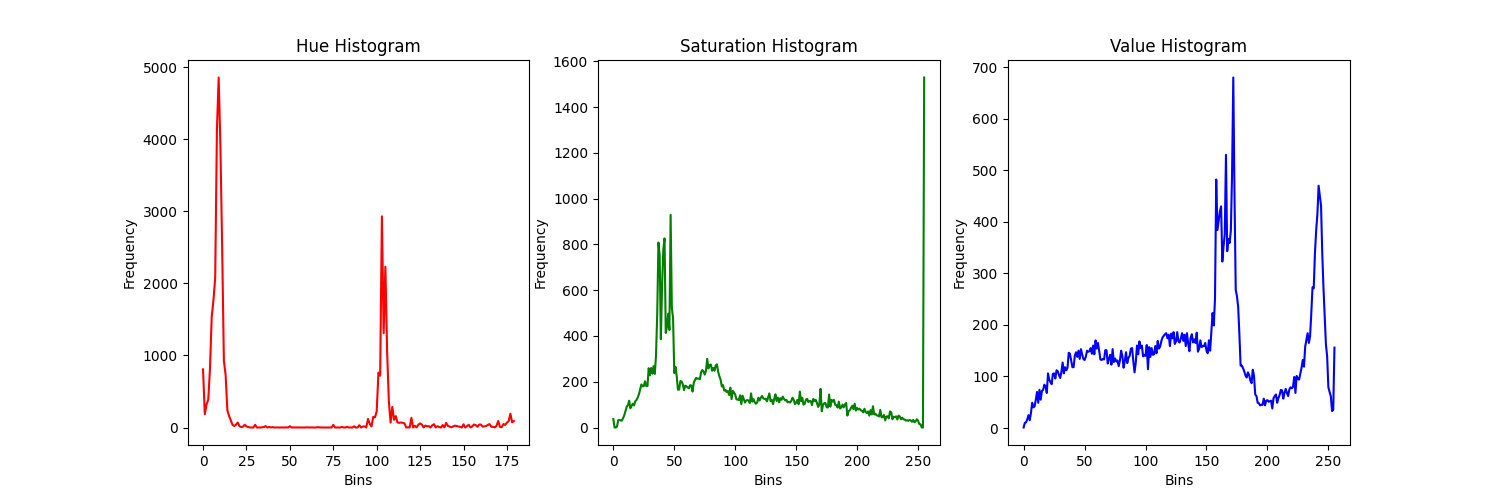
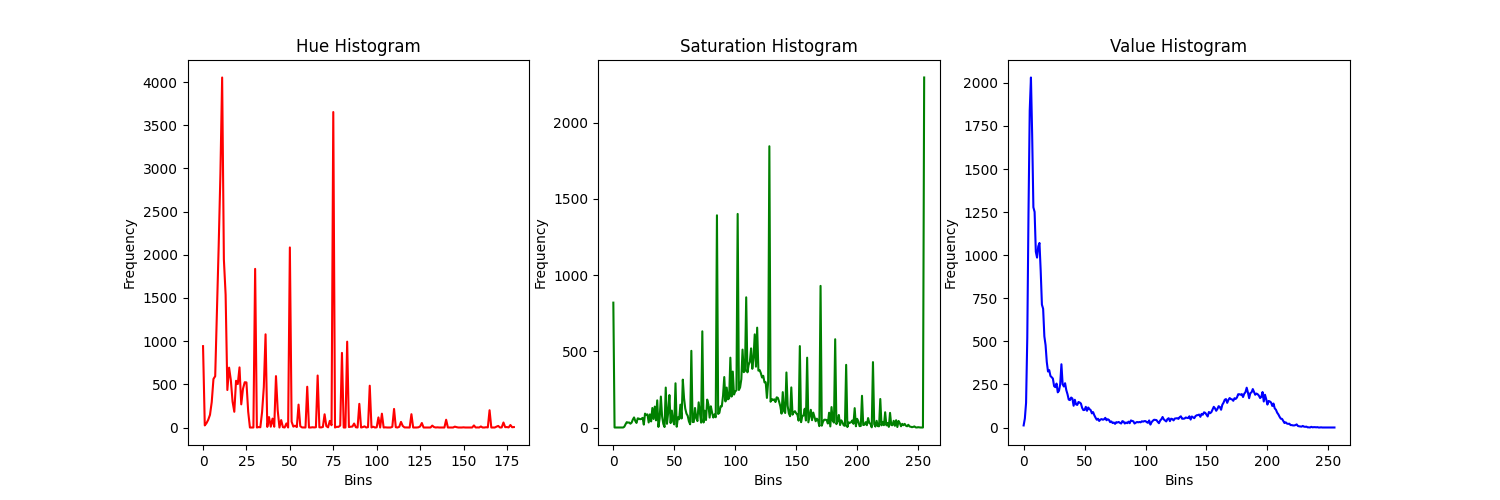
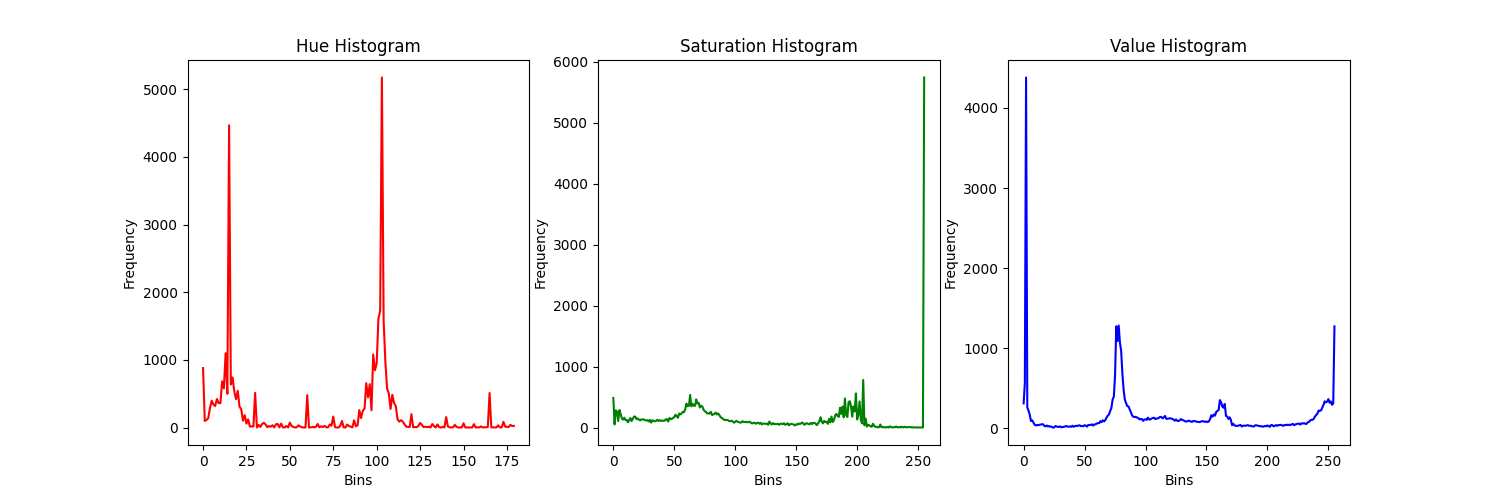
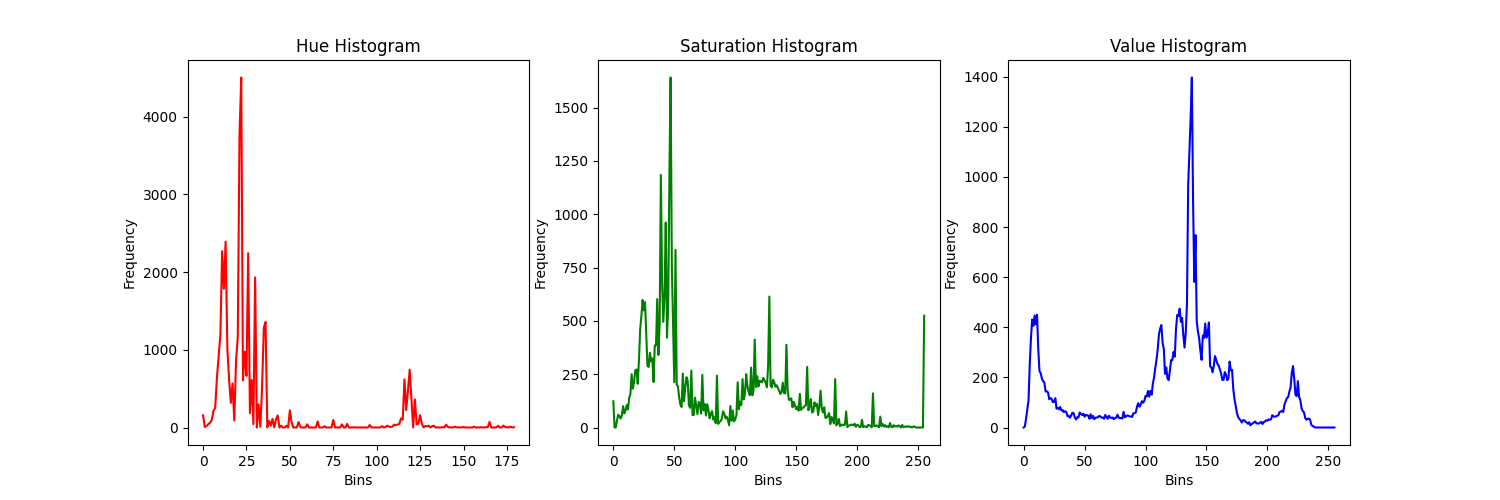
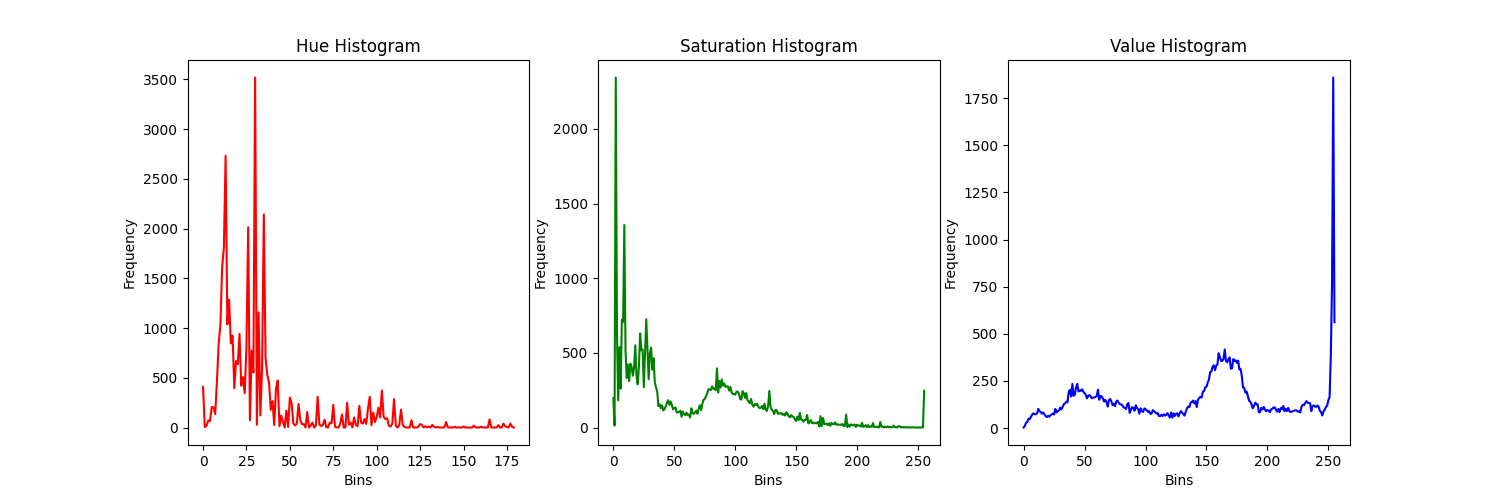
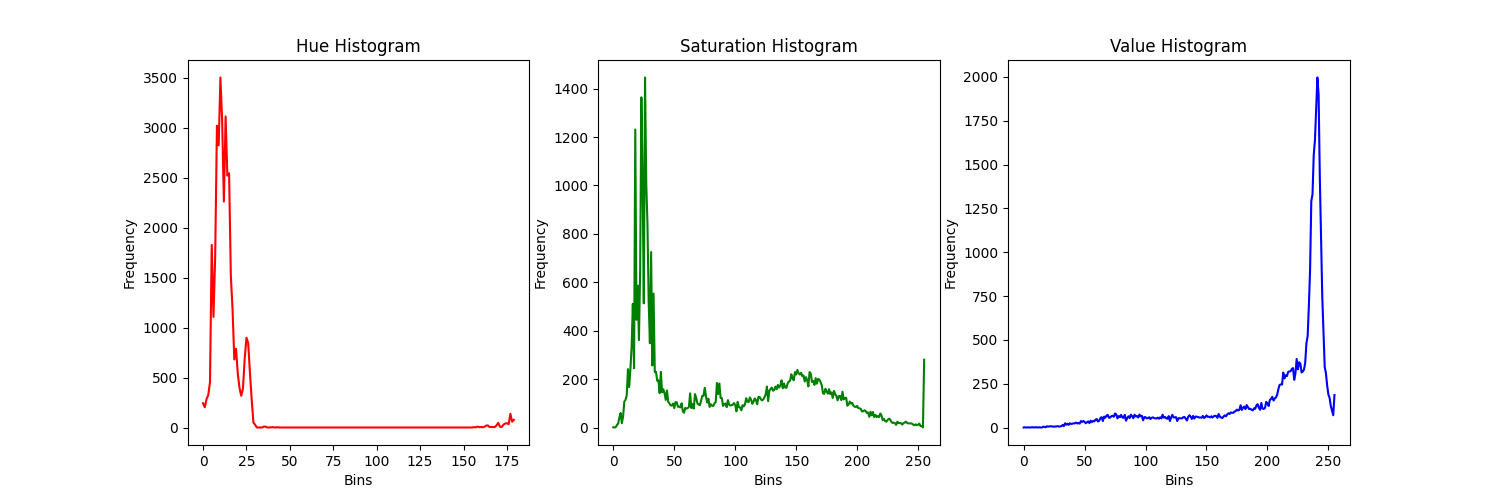
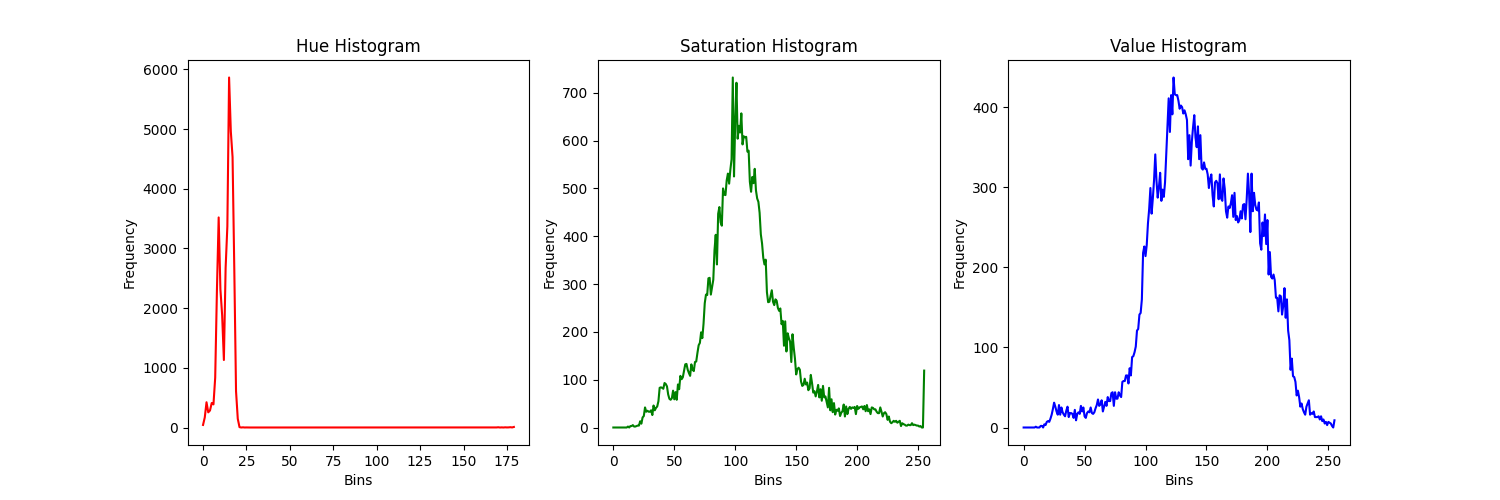
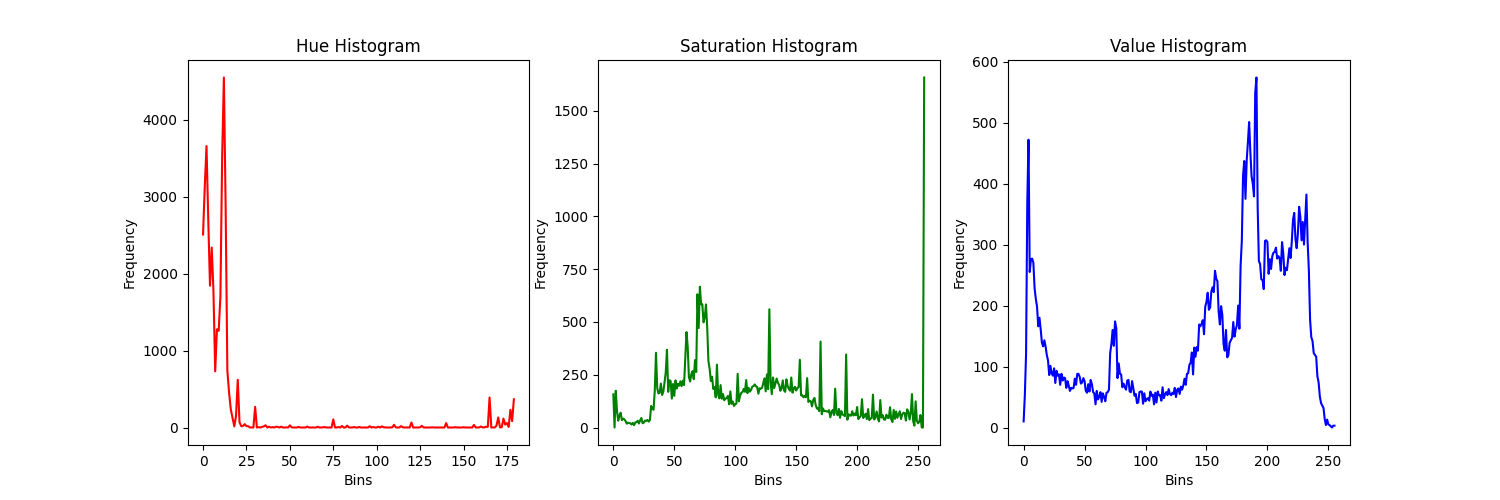
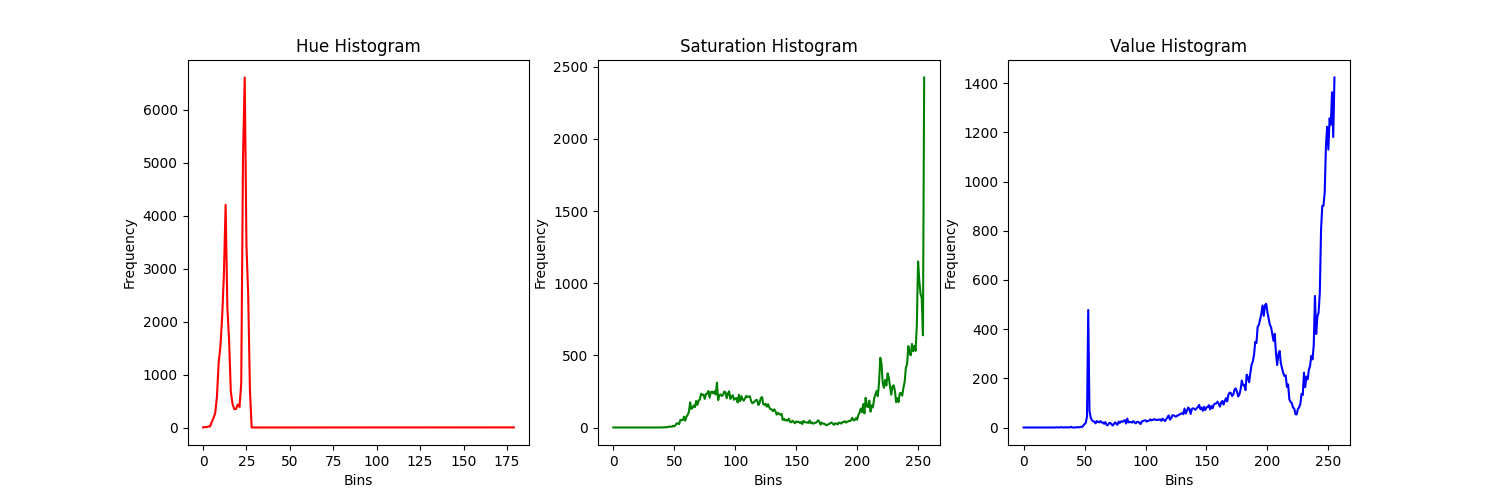
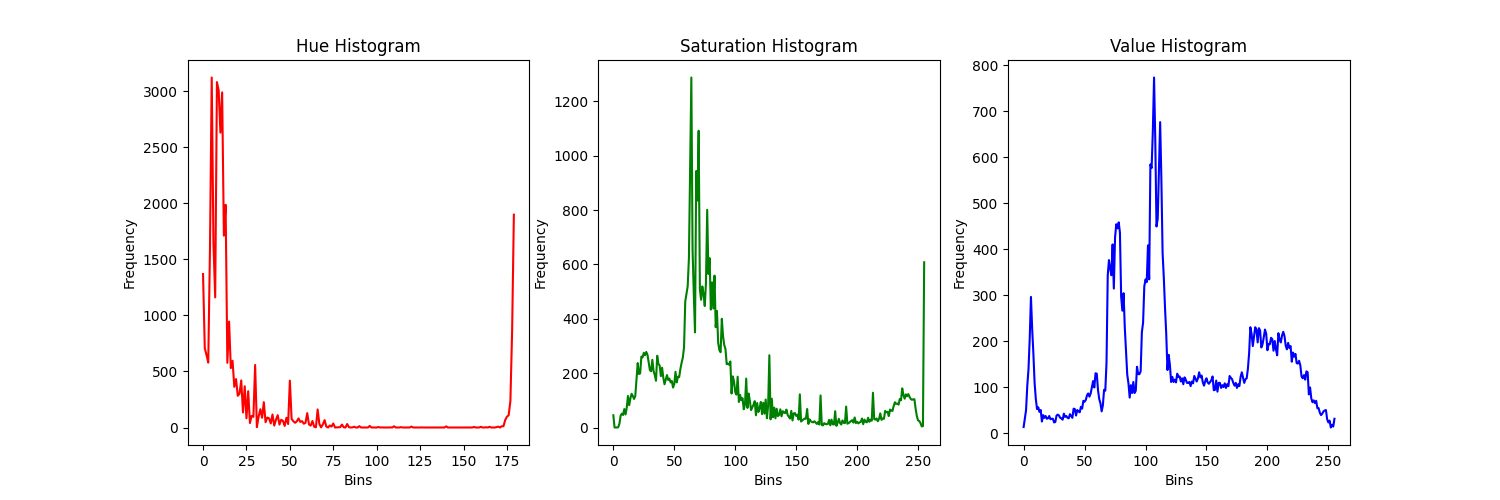
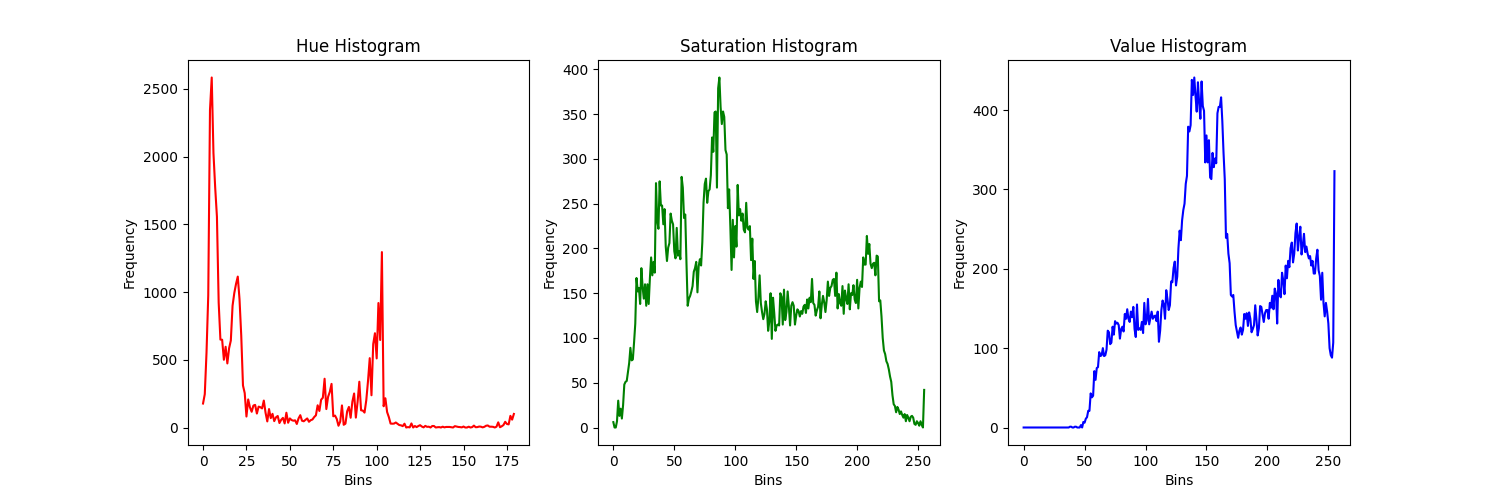
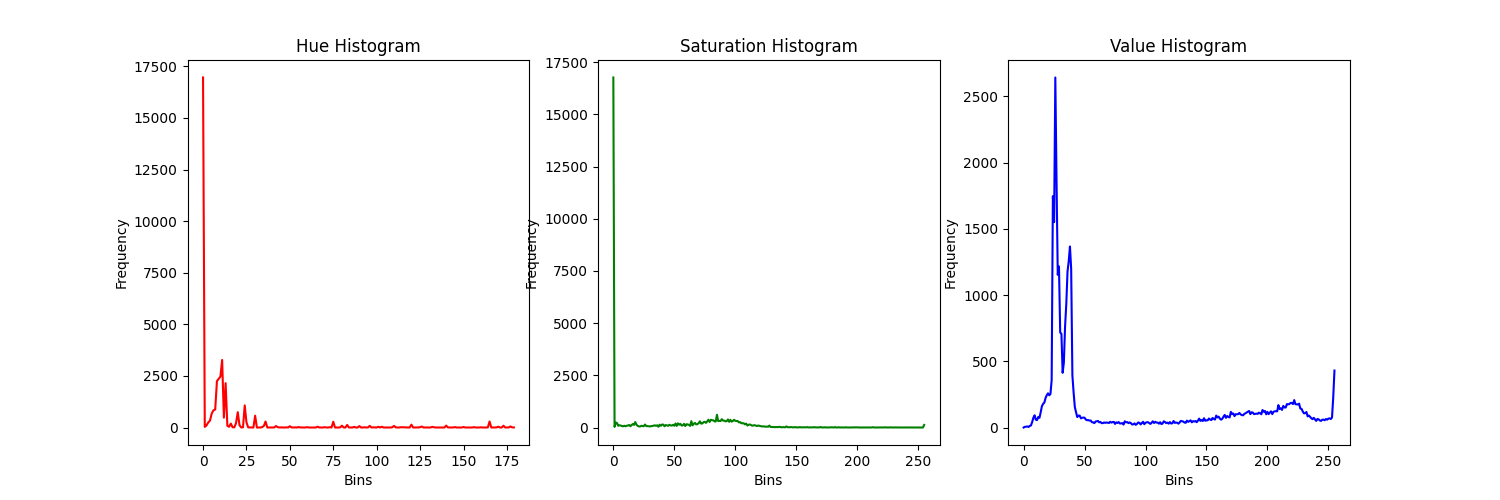
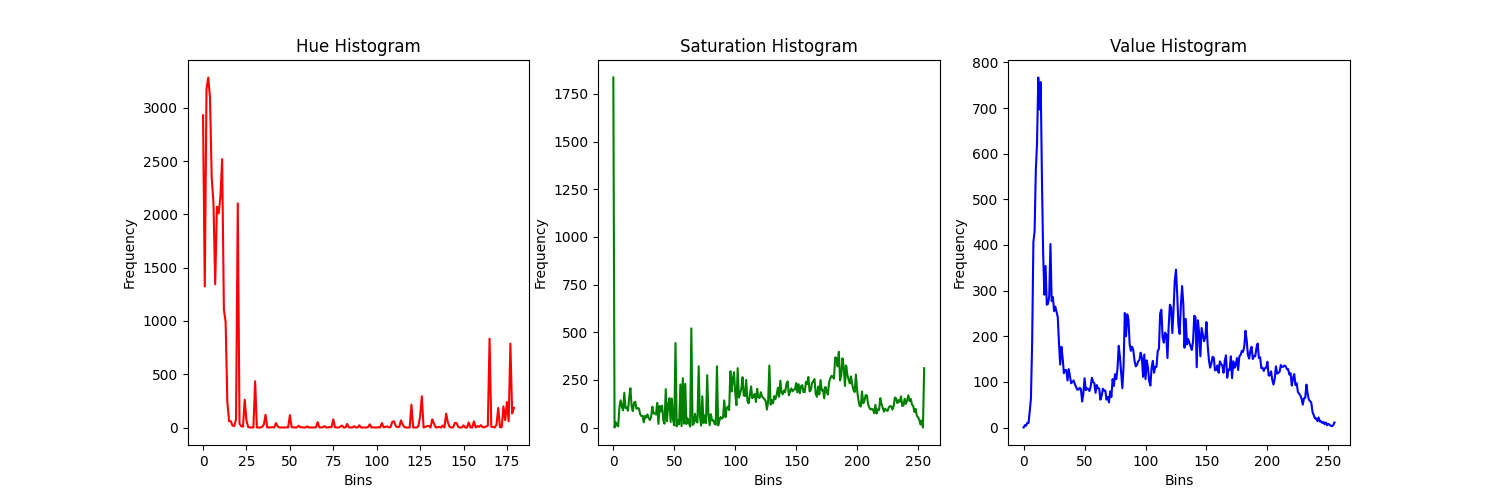
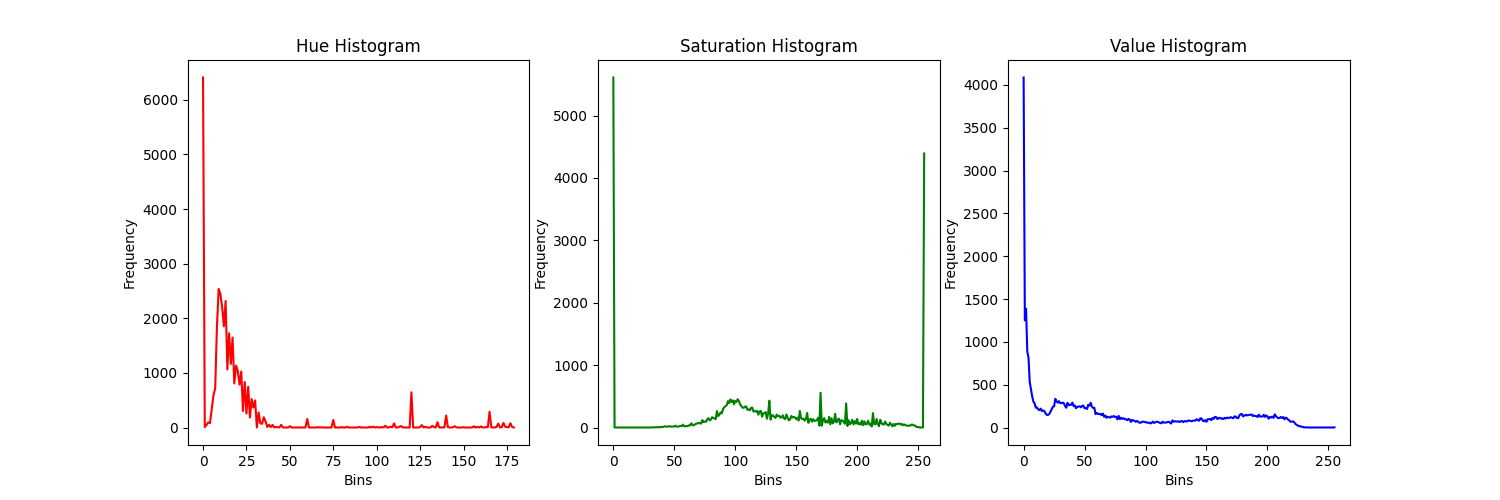
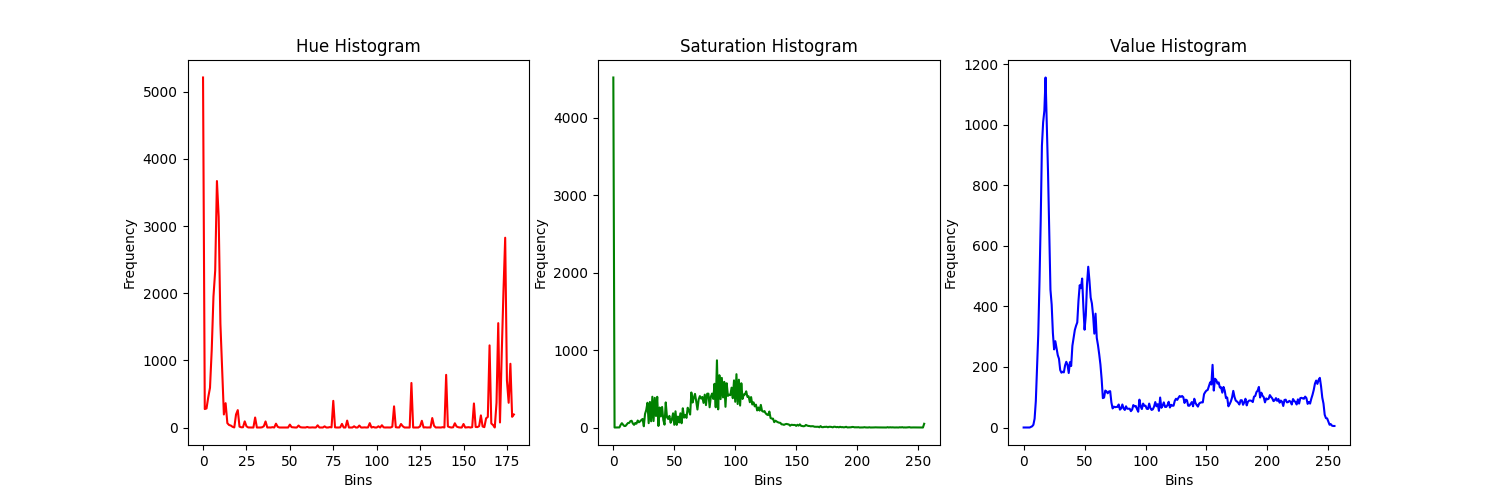
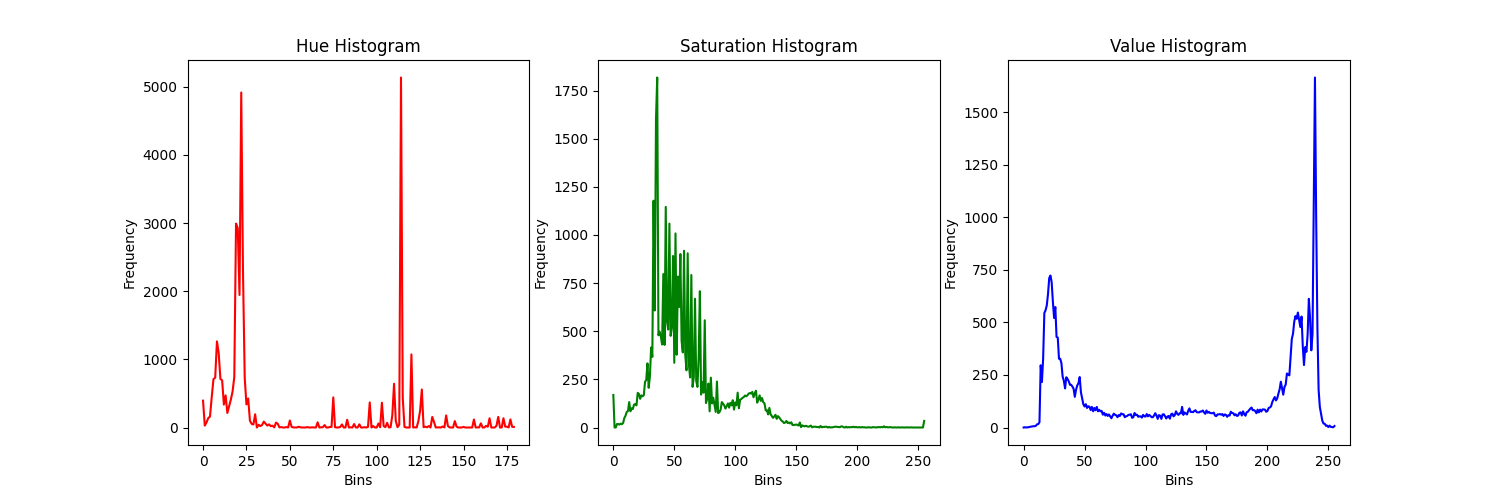
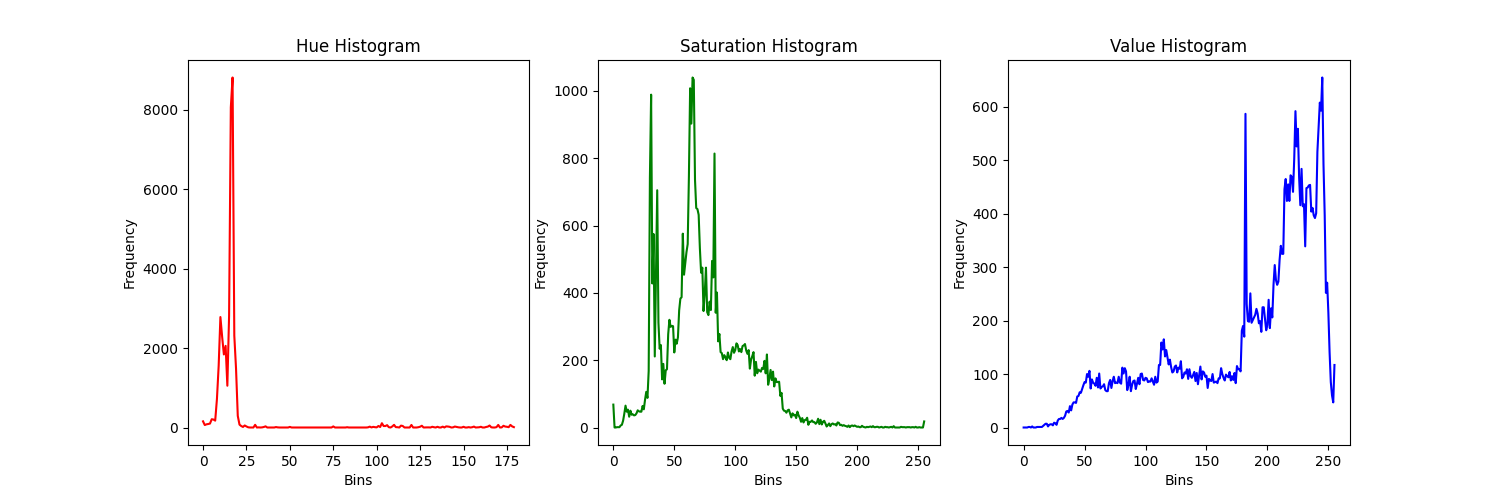
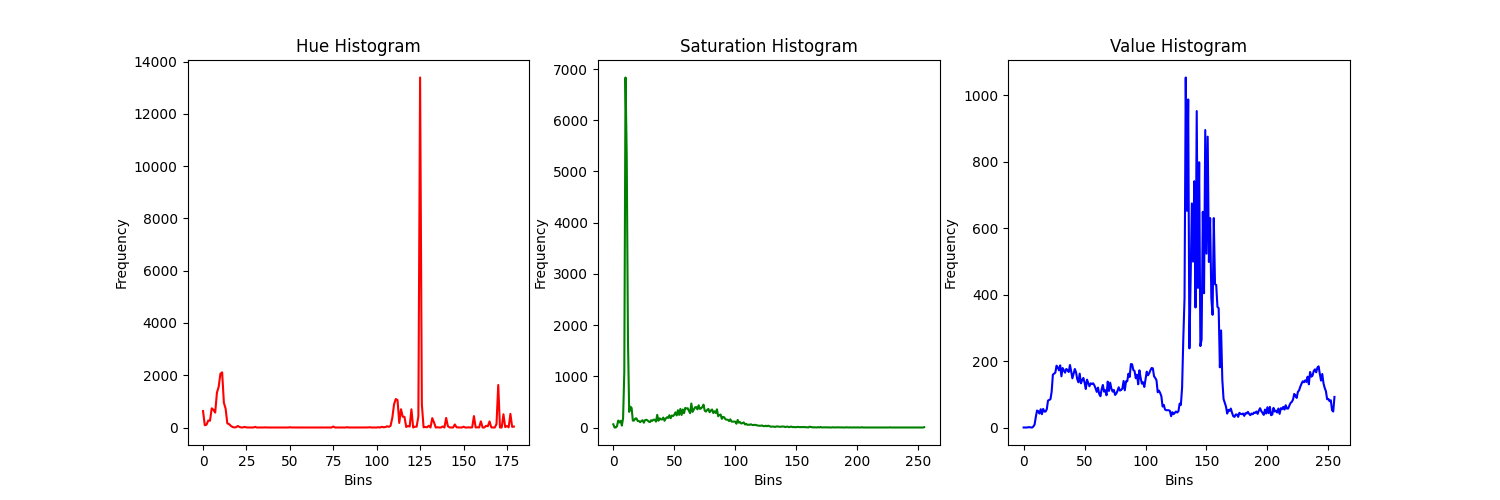
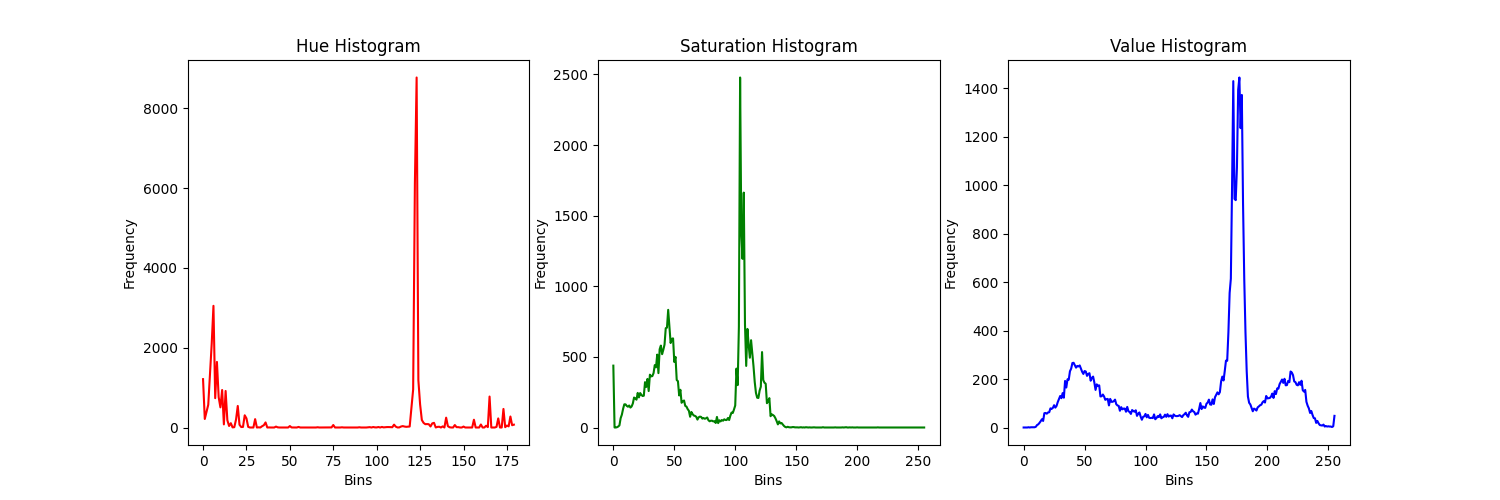
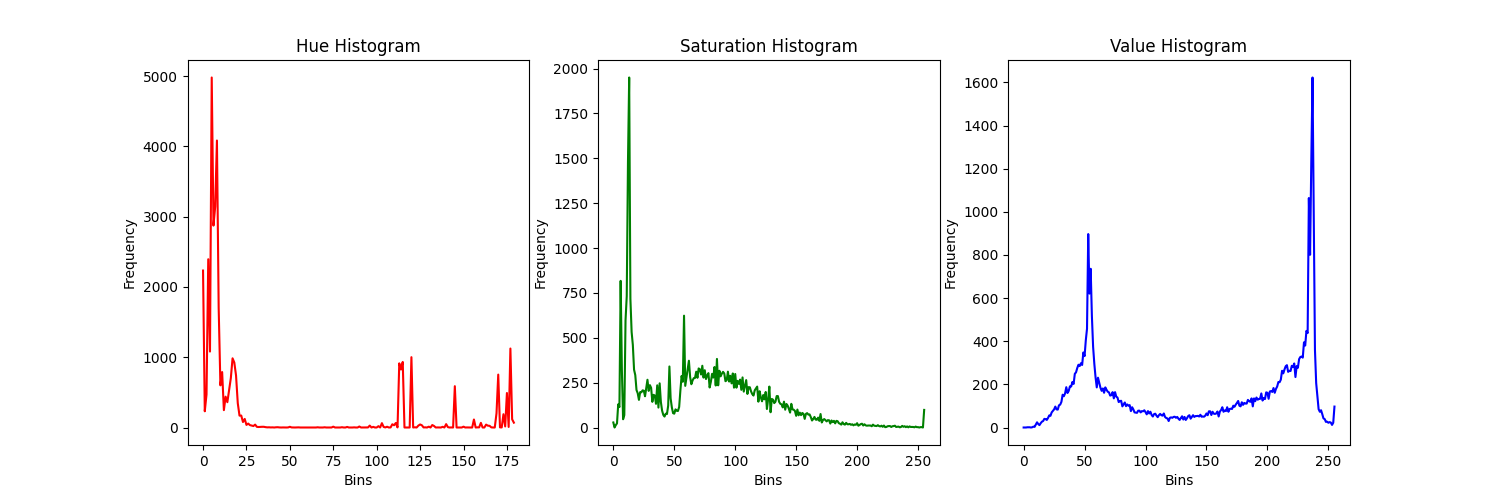
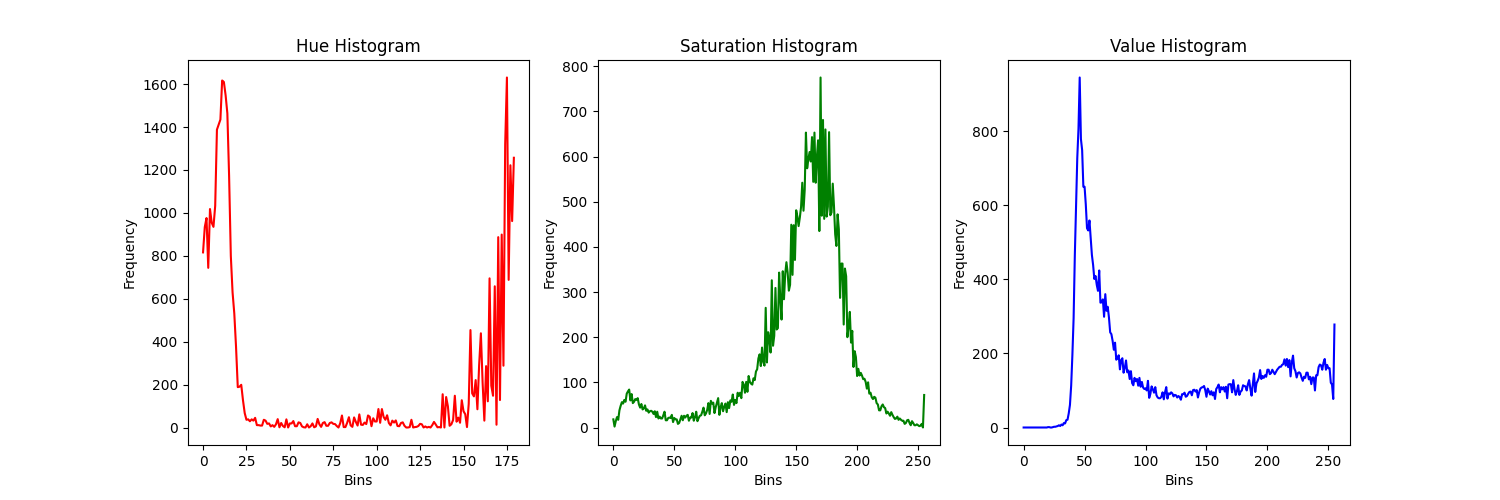
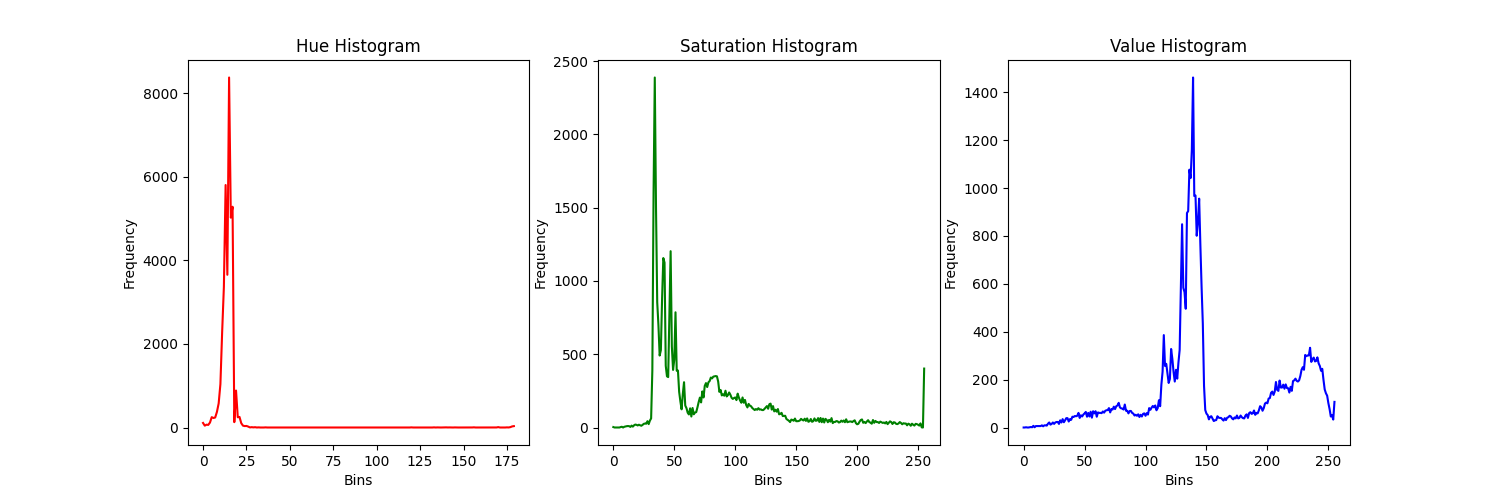
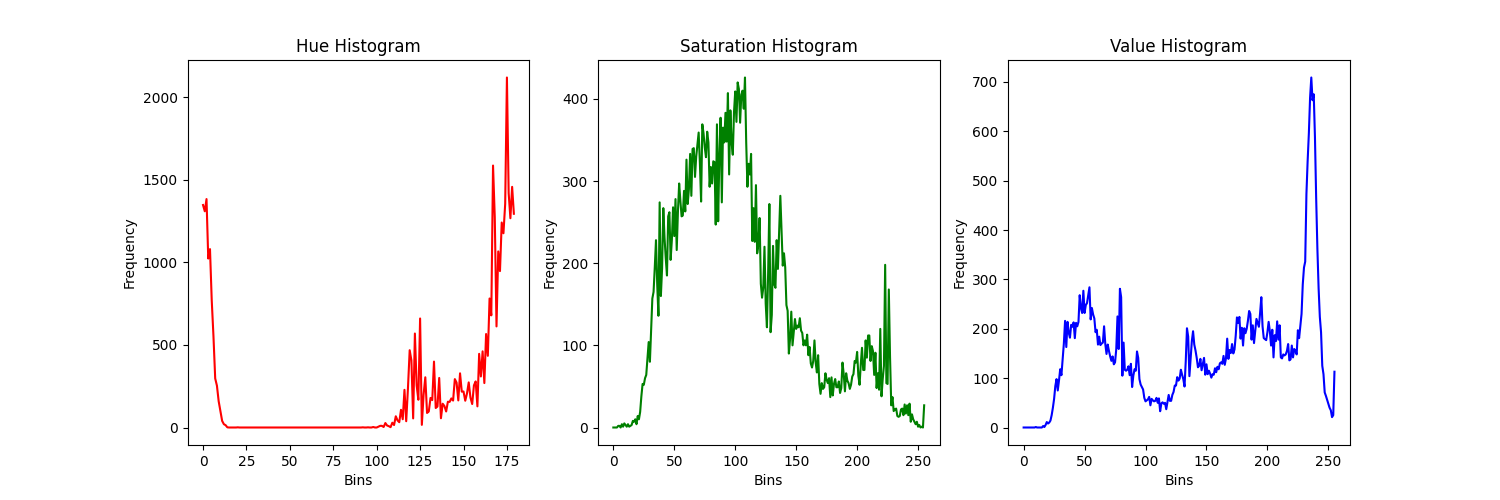
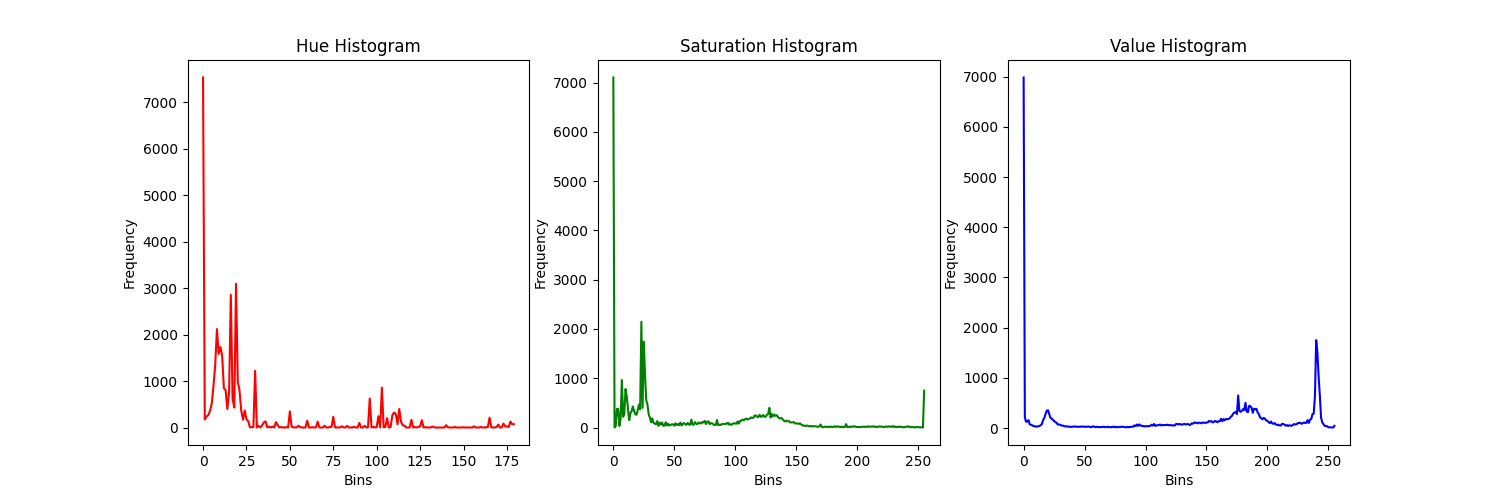
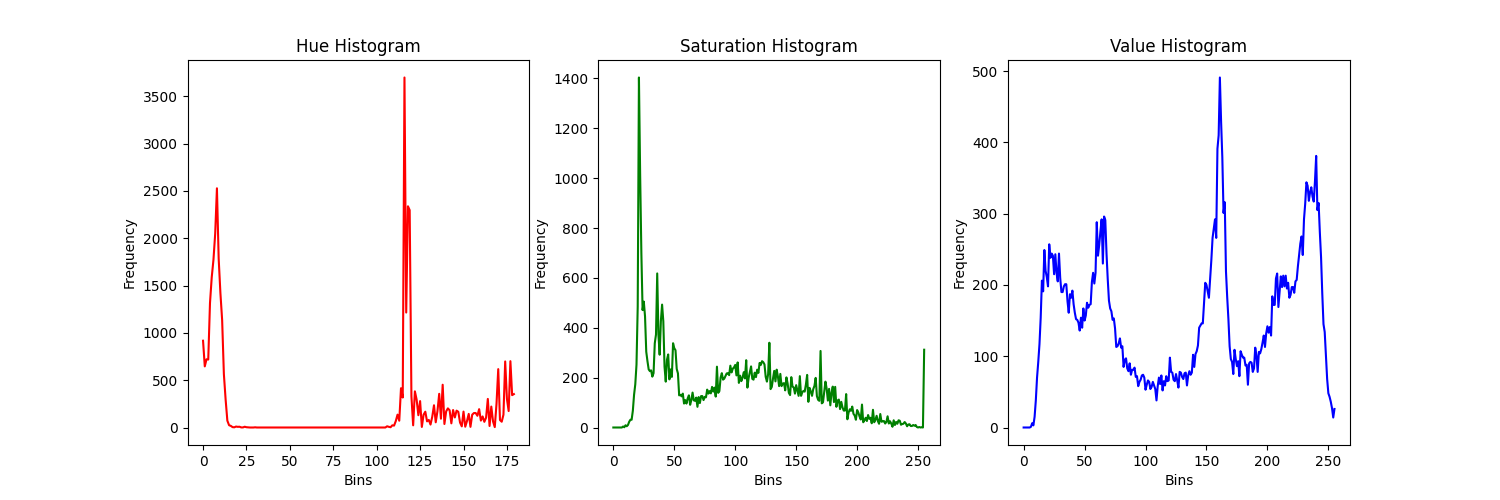
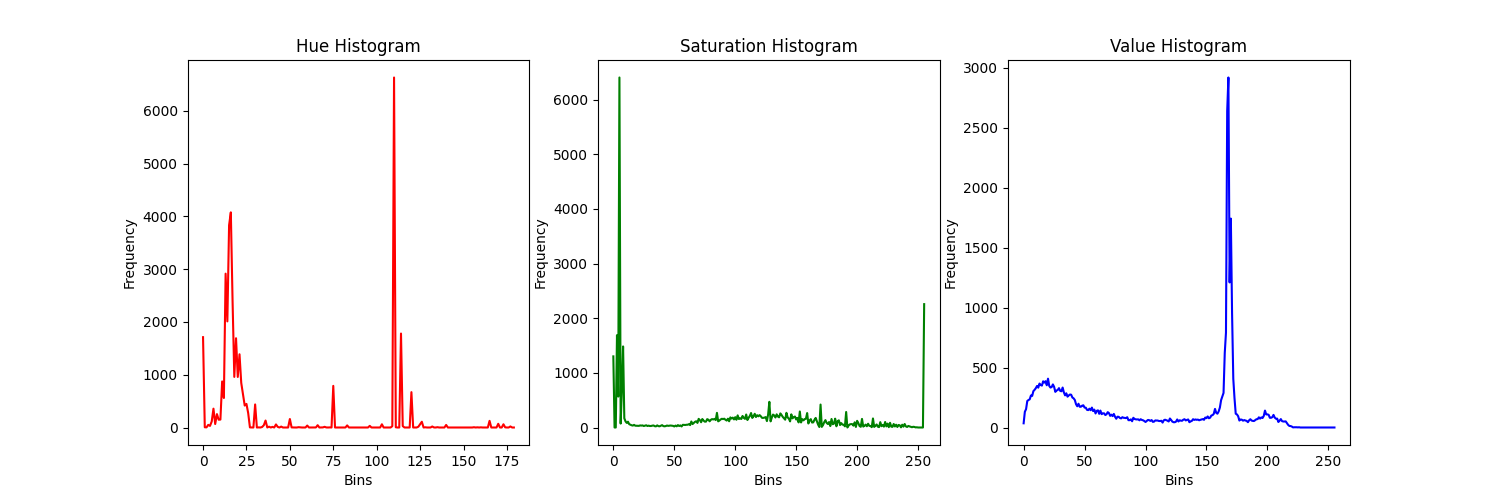
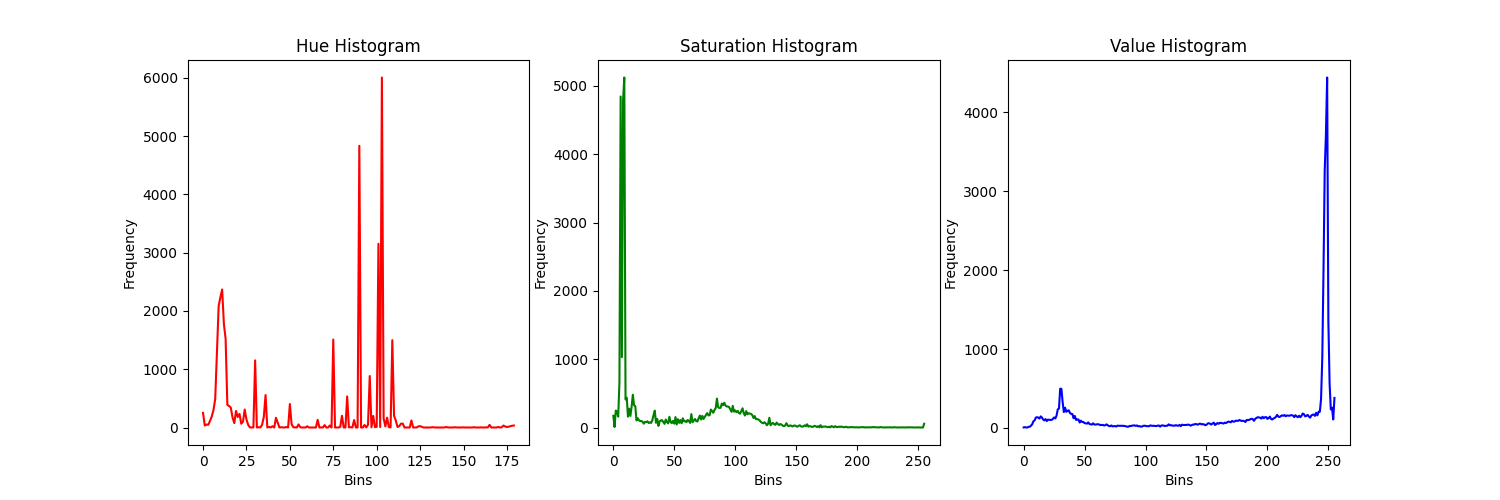
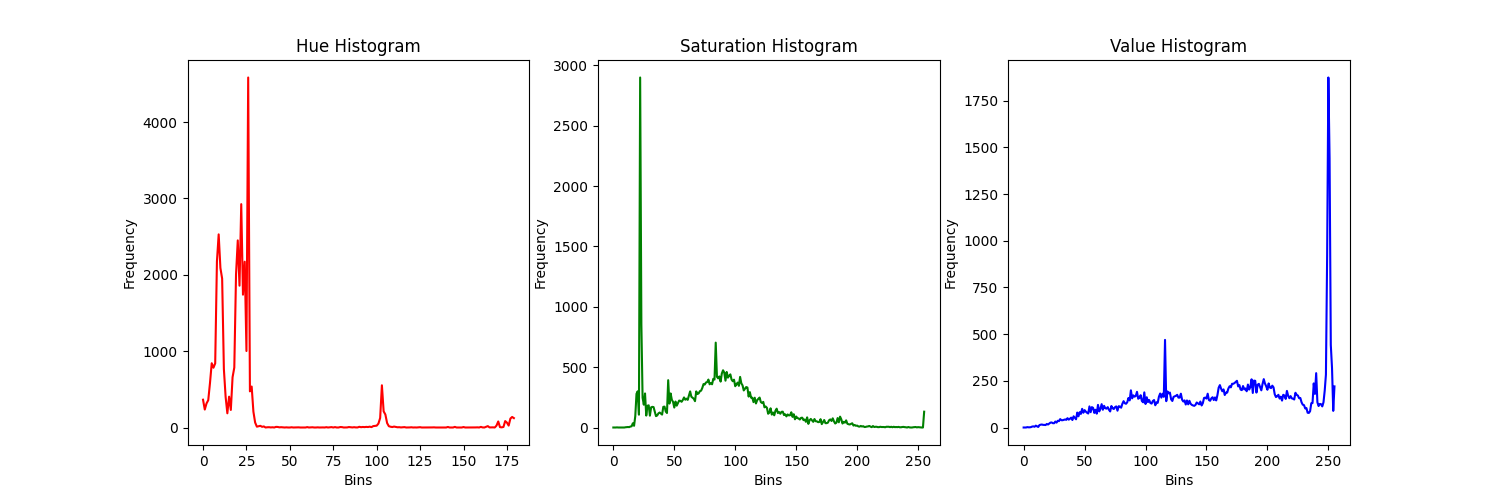
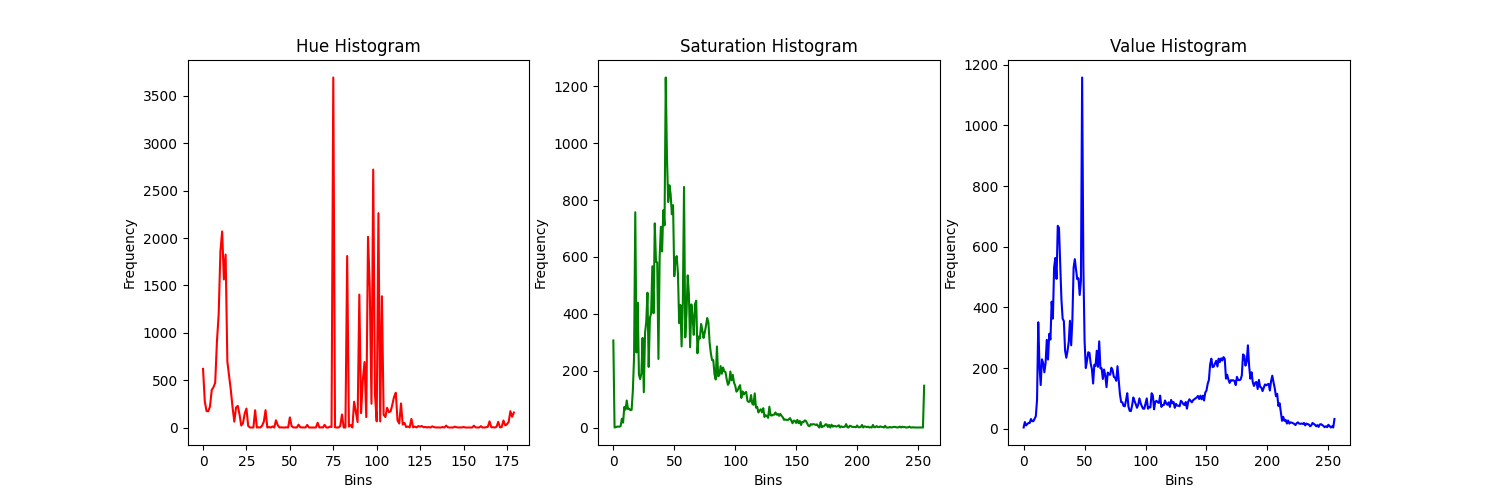
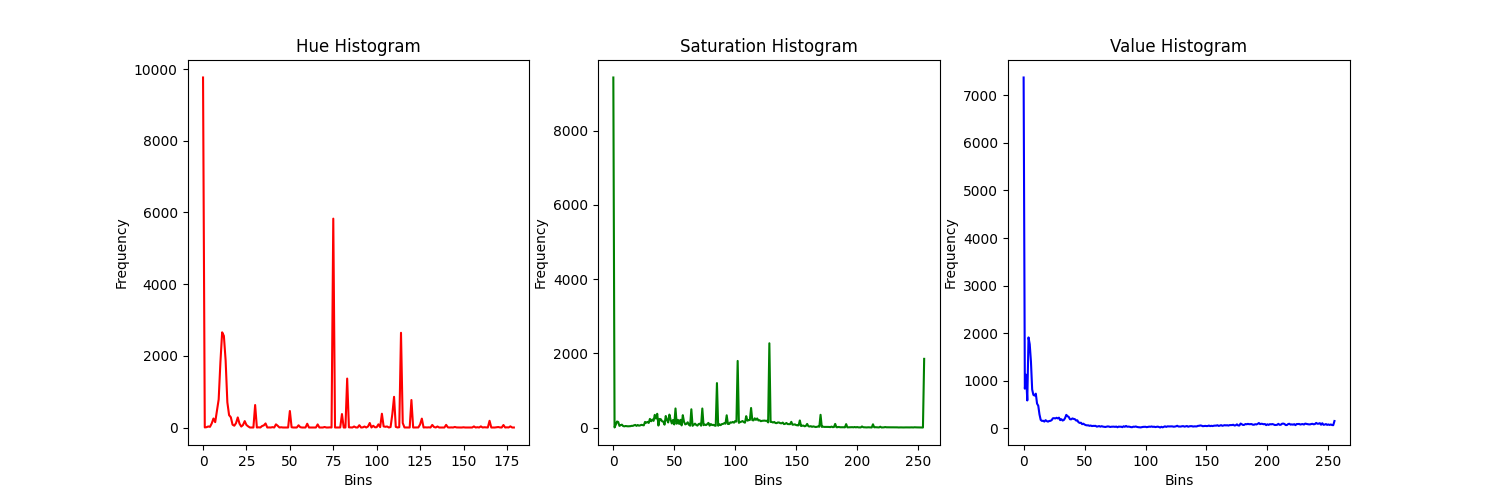
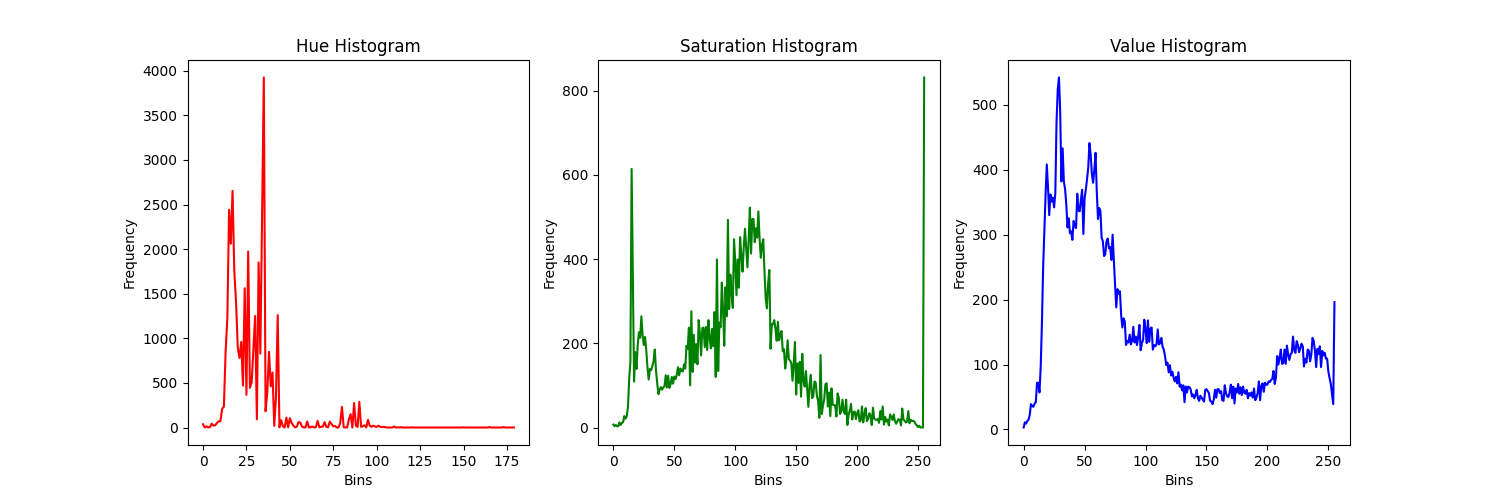

In [46]:
from tabulate import tabulate
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from IPython.display import display, HTML

def plot_histograms(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Calculate histograms
    hist_hue = cv2.calcHist([hsv], [0], None, [180], [0, 180])
    hist_saturation = cv2.calcHist([hsv], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv], [2], None, [256], [0, 256])
    
    # Plot histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].plot(hist_hue, color='r')
    axes[0].set_title('Hue Histogram')
    axes[0].set_xlabel('Bins')
    axes[0].set_ylabel('Frequency')
    
    axes[1].plot(hist_saturation, color='g')
    axes[1].set_title('Saturation Histogram')
    axes[1].set_xlabel('Bins')
    axes[1].set_ylabel('Frequency')
    
    axes[2].plot(hist_value, color='b')
    axes[2].set_title('Value Histogram')
    axes[2].set_xlabel('Bins')
    axes[2].set_ylabel('Frequency')
    
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plots_b64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()
    
    return f'<img src="data:image/png;base64,{plots_b64}" width="400" />'

# Assume image_stats_df_10 contains at least an 'Image Name' column with filenames
image_directory = 'Datasets/CELEBA/test_img'

# Create a copy of the DataFrame
image_stats_df_10 = image_stats_df.head(50).copy()

# Add 'Plots' column with plots
image_stats_df_10['Plots'] = image_stats_df_10.apply(lambda row: plot_histograms(os.path.join(image_directory, row['Image Name'])), axis=1)

# Drop unnecessary columns
image_stats_df_10.drop(columns=['Hue Histogram', 'Saturation Histogram', 'Value Histogram'], inplace=True)

# Display the DataFrame with HTML content
display(HTML(image_stats_df_10.to_html(escape=False)))



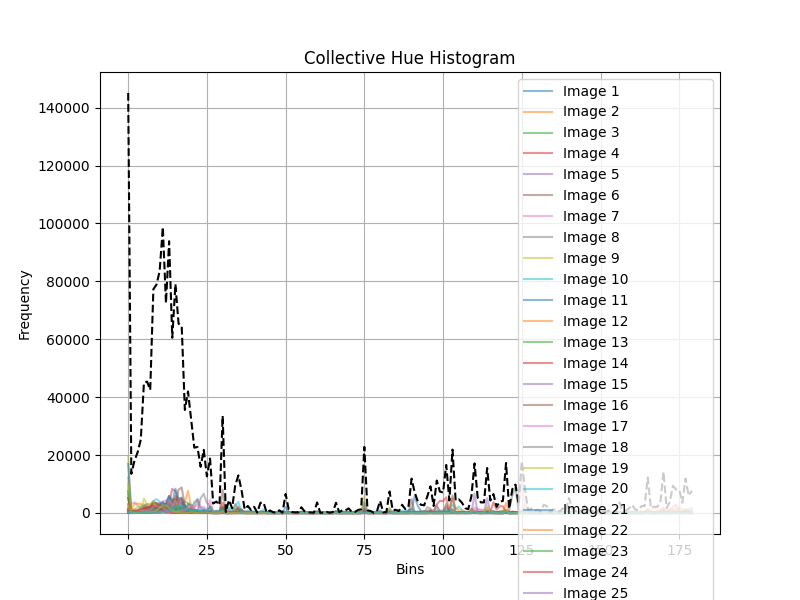

In [44]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import base64
from io import BytesIO
from IPython.display import display, HTML

def plot_hue_histogram(image_paths):
    all_hue_hist = []
    for idx, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hue_hist = cv2.calcHist([hsv], [0], None, [180], [0, 180])
        all_hue_hist.append(hue_hist)
    
    # Combine histograms
    collective_hist = np.sum(all_hue_hist, axis=0)
    
    # Plot collective histogram with labels
    plt.figure(figsize=(8, 6))
    for idx, hue_hist in enumerate(all_hue_hist):
        plt.plot(hue_hist, label=f'Image {idx+1}', alpha=0.5)
    plt.plot(collective_hist, color='k', linestyle='--', label='Collective Histogram')
    plt.title('Collective Hue Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    collective_plot_b64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()
    
    return f'<img src="data:image/png;base64,{collective_plot_b64}" width="600" />'

# Assume image_stats_df_10 contains at least an 'Image Name' column with filenames
image_directory = 'Datasets/CELEBA/test_img'

# List of image paths
image_paths = [os.path.join(image_directory, img_name) for img_name in image_stats_df_10['Image Name']]

# Create a collective hue histogram plot
collective_hue_hist_plot = plot_hue_histogram(image_paths)

# Display the collective histogram plot
display(HTML(collective_hue_hist_plot))



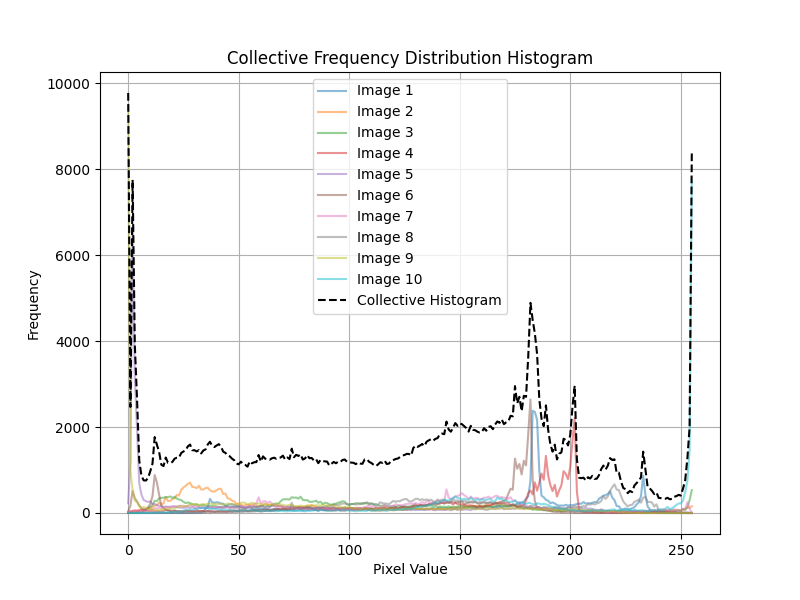

In [32]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import base64
from io import BytesIO
from IPython.display import display, HTML

def plot_frequency_histogram(image_paths):
    all_freq_hist = []
    for idx, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        freq_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        all_freq_hist.append(freq_hist)
    
    # Combine histograms
    collective_hist = np.sum(all_freq_hist, axis=0)
    
    # Plot collective histogram with labels
    plt.figure(figsize=(8, 6))
    for idx, freq_hist in enumerate(all_freq_hist):
        plt.plot(freq_hist, label=f'Image {idx+1}', alpha=0.5)
    plt.plot(collective_hist, color='k', linestyle='--', label='Collective Histogram')
    plt.title('Collective Frequency Distribution Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    collective_plot_b64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()
    
    return f'<img src="data:image/png;base64,{collective_plot_b64}" width="600" />'

# Assume image_stats_df_10 contains at least an 'Image Name' column with filenames
image_directory = 'Datasets/CELEBA/test_img'

# List of image paths
image_paths = [os.path.join(image_directory, img_name) for img_name in image_stats_df_10['Image Name']]

# Create a collective frequency histogram plot
collective_freq_hist_plot = plot_frequency_histogram(image_paths)

# Display the collective histogram plot
display(HTML(collective_freq_hist_plot))



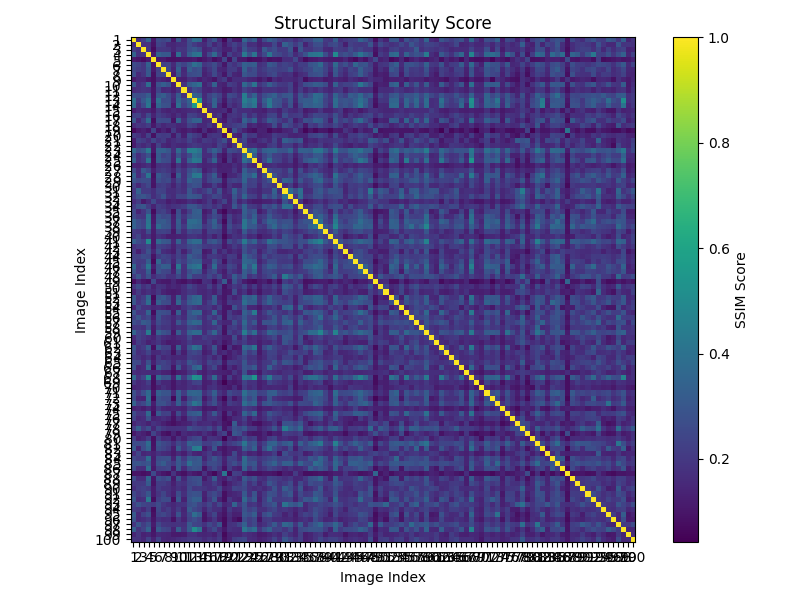

In [39]:
# List of image paths
image_paths = [os.path.join(image_directory, img_name) for img_name in image_stats_df_10['Image Name']]

# Create a similarity score plot
similarity_score_plot = plot_similarity_score(image_paths)

# Display the similarity score plot
display(HTML(similarity_score_plot))

In [12]:
import cv2

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the pre-trained facial landmark detector
modelFile = "res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

# Load an image
image = cv2.imread('path_to_image.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Iterate over the detected faces
for (x, y, w, h) in faces:
    # Draw a bounding box around the face
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Extract the face ROI
    face_roi = image[y:y+h, x:x+w]

    # Detect facial landmarks
    blob = cv2.dnn.blobFromImage(cv2.resize(face_roi, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    landmarks = net.forward()

    # Draw facial landmarks on the face
    for i in range(0, landmarks.shape[2]):
        confidence = landmarks[0, 0, i, 2]
        if confidence > 0.5:  # Confidence threshold
            x_lm = int(landmarks[0, 0, i, 0] * w)
            y_lm = int(landmarks[0, 0, i, 1] * h)
            cv2.circle(image, (x + x_lm, y + y_lm), 1, (0, 0, 255), -1)

# Display the image with faces and facial landmarks
cv2.imshow('Facial Landmarks', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\caffe\caffe_io.cpp:1126: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "deploy.prototxt" in function 'cv::dnn::ReadProtoFromTextFile'


In [2]:
from keras.models import Sequential

import tensorflow as tf

import tensorflow_datasets as tfds

tf.enable_eager_execution()

from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *
from PIL import Image
import theano

ModuleNotFoundError: No module named 'tensorflow.python'

In [1]:
import tensorflow as tf
print(tf.__version__)


ModuleNotFoundError: No module named 'tensorflow.python'